In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats

In [2]:
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

# display plots in this notebook
%matplotlib inline

In [3]:
import sys
import os
import re
import collections
import HTSeq
import networkx as nx

# machine learning

In [4]:
def get_auc_list(fname):
    with open(fname, 'r') as f:
        output = f.read()
    return [float(item) for item in re.findall('train auc: (\S+)', output)], [float(item) for item in re.findall('test auc: (\S+)', output)]

In [5]:
def get_feature_importance_list(fname):
    feature_importance_list = []
    with open(fname, 'r') as f:      
        output = f.read()
        for item in re.findall(r'\((.+?, .+?\d+?)\)', output):
            feature, importance = re.search(r"'(\S+)', (.+)", item).group(1), 
            float(re.search(r"'(\S+)', (.+)", item).group(2))
            feature_importance_list.append((feature, importance))
    return feature_importance_list

## validation for IR-high introns and IR-low introns

In [6]:
pwd

u'/mnt/d/bioproject/IR/scripts_results'

In [29]:
PATH_FOLDER='/mnt/d/bioproject/IR/scripts_results/zz_results'
data_path = PATH_FOLDER + '/Human_summary/IRI/introns/'

num_samples = len(os.listdir(data_path))
df_list = []
for data_full_path in [os.path.join(data_path, f) for f in os.listdir(data_path) if re.search('introns.txt$', f)]:
    df = pd.read_csv(data_full_path, header=0, sep='\t', na_values=['NA', "NA (5'AS)", "NA (3'AS)", "NA (unannotated exon)"]).loc[:,['CIR_id', 'adjacent_CER_RPKM', 'intron_IRI']]
    df = df[(df.intron_IRI >= 0) & (df.intron_IRI <= 1) & (df.adjacent_CER_RPKM >= 0.1)].drop(['adjacent_CER_RPKM'], axis=1).set_index('CIR_id')
    df_list.append(df)    

    
num_IRI_high_CIRs = 5000
num_IRI_low_CIRs = 5000
IRI_df = pd.concat(df_list, axis=1).dropna()
IRI_df['mean_intron_IRI'] = IRI_df.apply(lambda row: np.mean(row[:num_samples]), axis=1)

IRI_high_df = IRI_df.sort_values(by='mean_intron_IRI', ascending=False).iloc[:num_IRI_high_CIRs].loc[:, ['mean_intron_IRI']]
IRI_high_df['type'] = 'IRI-high'

IRI_low_df = IRI_df.sort_values(by='mean_intron_IRI').iloc[:num_IRI_low_CIRs].loc[:, ['mean_intron_IRI']]
IRI_low_df['type'] = 'IRI-low'


####  the following was trying to use CER+RPKM for plot

#CER_RPKM = pd.concat(df_list, axis=1).dropna()
#CER_RPKM['mean_adjacent_CER_RPKM'] = CER_RPKM.apply(lambda row: np.mean(row[:num_samples]), axis=1)
#CER_RPKM_high = CER_RPKM.sort_values(by='mean_adjacent_CER_RPKM', ascending=False).iloc[:num_IRI_high_CIRs].loc[:, ['mean_adjacent_CER_RPKM']]
#CER_RPKM_high['type'] = 'IRI-high'

#IRI_low_df = IRI_df.sort_values(by='mean_adjacent_CER_RPKM').iloc[:num_IRI_low_CIRs].loc[:, ['mean_adjacent_CER_RPKM']]
#IRI_low_df['type'] = 'IRI-low'

In [22]:
boxplot_df = pd.concat([IRI_high_df, IRI_low_df], axis=0)
boxplot_df.groupby('type').count()

,mean_intron_IRI
type,
IRI-high,5000
IRI-low,5000


0.0


/home/Xiang/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


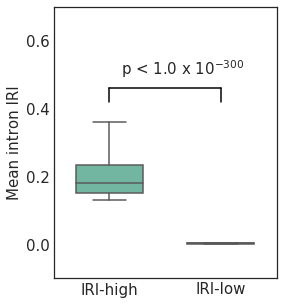

In [23]:
sns.set_style("white")

sns.set_palette(sns.color_palette("Set2", 2))

plt.figure(figsize=(4,5))
ax = sns.boxplot(x='type', y='mean_intron_IRI', data=boxplot_df, showfliers=False, width=0.6)
ax.locator_params(nbins=5, axis='y')

box_upper_y_list = []

for i,artist in enumerate(ax.artists):
    color = artist.get_facecolor()
    for j in range(i*5, i*5+5):
        line = ax.lines[j]     
        if j % 5 in [2,3]:
            if j % 5 == 3:
                box_upper_y_list.append(line.get_ydata()[0])

plt.ylim([-0.1, 0.7])
plt.ylabel('Mean intron IRI', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('', fontsize=20)
plt.legend(loc = 'upper right', fontsize=22, ncol=1)

cutoff = 1.0
pvalue = scipy.stats.mannwhitneyu(boxplot_df[boxplot_df.type == 'IRI-high'].mean_intron_IRI / cutoff, boxplot_df[boxplot_df.type == 'IRI-low'].mean_intron_IRI, alternative='greater')[1]
print pvalue
if pvalue != 0:
    sign = '='
    digit, exp = re.search(r'(\S+)e(\S+)' , '%.1e' % pvalue).group(1,2)
else:
    sign, digit, exp = '<', '1.0', '-300'   ##"Why?"
plt.text(0.1, box_upper_y_list[0]+0.14, r'p {} {} x $10^{{{}}}$'.format(sign, digit, int(exp)), fontsize=15)
    
line_ax = plt.axhline(y=box_upper_y_list[0]+0.1, xmin=(0.25), xmax=(0.75), color='k')
plt.axvline(x=line_ax.get_xdata()[0] * 2 - 0.5, ymin=(line_ax.get_ydata()[0] - 0.04 + 0.1)/0.8, ymax=(line_ax.get_ydata()[0] + 0.1)/0.8, color='k')
plt.axvline(x=line_ax.get_xdata()[1] * 2 - 0.5, ymin=(line_ax.get_ydata()[0] - 0.04 + 0.1)/0.8, ymax=(line_ax.get_ydata()[0] + 0.1)/0.8, color='k')



## overall

### GBTree

In [30]:
auc_dict = {}

data_path = PATH_FOLDER + '/ML_data/exp_IRI_intron_level_splicing'
for fname in filter(lambda f: re.search('exp_gbtree\S+log', f), os.listdir(data_path)):
    feature = re.search('exp_gbtree_add_(\S+).log', fname).group(1)
    auc_dict[feature] = get_auc_list(os.path.join(data_path, fname))[1]
#
#auc_dict = dict([(k, v) for k, v in auc_dict.items() if 'ss' not in k and 'polII' not in k]  )

In [31]:
legend_base_dict = {'distance': 'distance to TES', 'motif': 'RBP motif', 'eclip': 'RBP eCLIP', 'polII': 'polII', 'ss': 'splice site score', 'geneRPKM':'gene RPKM'}

legend_base_dict = {'CD4_Rest_gene_RPKM': 'CD4 Rest gene RPKM','CD8_Rest_gene_RPKM': 'CD8 Rest gene RPKM',
                    'distance_to_TES': 'distance to TES' }
#legend_base_dict = {'human_gene_RPKM', 'polII', 'distance_polII'}

In [32]:
legend_dict = {}
for feat_list_str in auc_dict.keys():
    legend_dict[feat_list_str] = ' + '.join([legend_base_dict[x] for x in feat_list_str.split('_')])     

KeyError: 'CD4'

In [33]:
filter(lambda f: re.search('exp_gbtree\S+log', f), os.listdir(data_path))
re.search('exp_gbtree_add_(\S+).log',  'exp_gbtree_add_gene_RPKM.log').group(1)
auc_dict.keys()

['CD4_Rest_gene_RPKM', 'distance_to_TES', 'CD8_Rest_gene_RPKM']

In [36]:
boxplot_tuple = []
for feature in ['CD4_Rest_gene_RPKM', 'distance_to_TES', 'CD8_Rest_gene_RPKM']:
    for auc in auc_dict[feature]:
        boxplot_tuple.append((legend_base_dict[feature], auc))
re.search('exp_gbtree_add_(\S+).log', fname).group(1)        

'distance_to_TES'

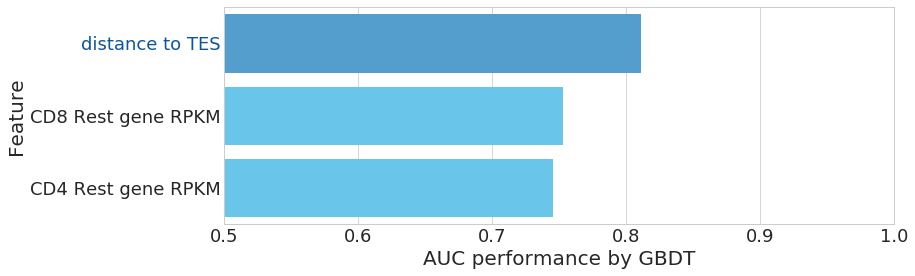

In [37]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,4))
ax = sns.barplot(boxplot_mean_df, boxplot_mean_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by GBDT', fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel('Feature', fontsize=20)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

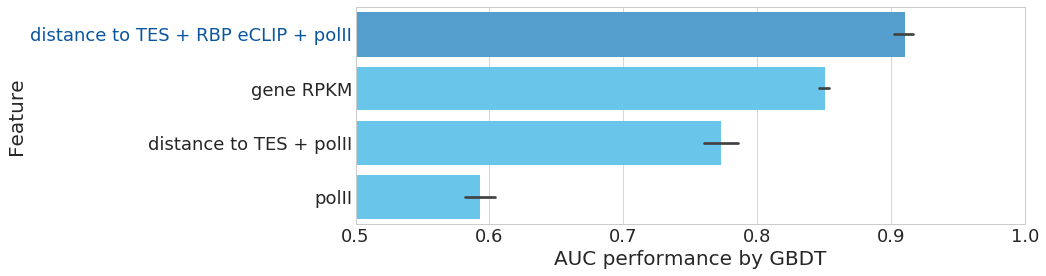

In [46]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

boxplot_errorbar_df = boxplot_df.set_index('feature')[['test auc']]
boxplot_errorbar_df['mean'] = boxplot_df.groupby('feature')['test auc'].mean()
boxplot_errorbar_df.sort_values(by='mean', ascending=False, inplace=True)
boxplot_errorbar_df = boxplot_errorbar_df['test auc']

plt.figure(figsize=(12,4))
ax = sns.barplot(boxplot_errorbar_df, boxplot_errorbar_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by GBDT', fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel('Feature', fontsize=20)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

In [47]:
boxplot_tuple = []
#for feature in ['ss', 'motif', 'eclip', 'motif_eclip', 'ss_motif_eclip']:
for feature in ['ss', 'motif', 'ss_motif']:
    for auc in auc_dict[feature]:
        boxplot_tuple.append((legend_dict[feature], auc))

KeyError: 'ss'

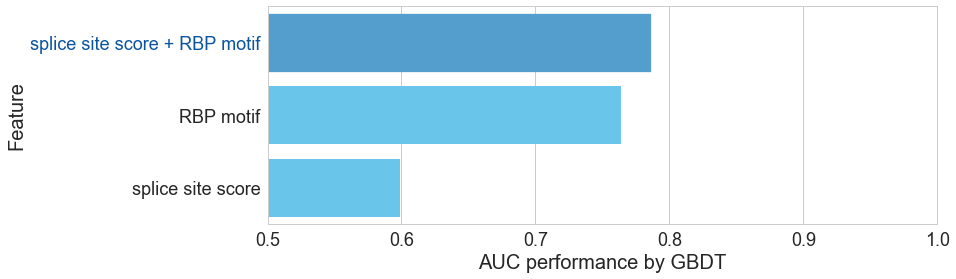

In [38]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,4))
ax = sns.barplot(boxplot_mean_df, boxplot_mean_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by GBDT', fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel('Feature', fontsize=20)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

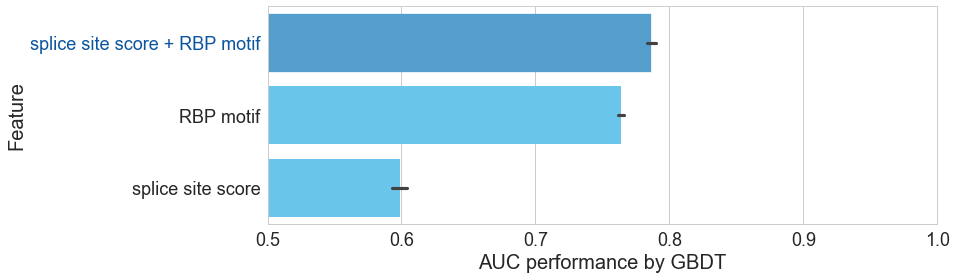

In [39]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

boxplot_errorbar_df = boxplot_df.set_index('feature')[['test auc']]
boxplot_errorbar_df['mean'] = boxplot_df.groupby('feature')['test auc'].mean()
boxplot_errorbar_df.sort_values(by='mean', ascending=False, inplace=True)
boxplot_errorbar_df = boxplot_errorbar_df['test auc']

plt.figure(figsize=(12,4))
ax = sns.barplot(boxplot_errorbar_df, boxplot_errorbar_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by GBDT', fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel('Feature', fontsize=20)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

### LR

In [21]:
auc_dict = {}

data_path = '/Users/zzeng/Documents/GitHub/ML_code/exp_IRI_intron_level_splicing'
for fname in filter(lambda f: re.search('exp_LR\S+log', f), os.listdir(data_path)):
    feature = re.search('exp_LR_st_add_(\S+).log', fname).group(1)
    auc_dict[feature] = get_auc_list(os.path.join(data_path, fname))[1]

#auc_dict = dict([(k, v) for k, v in auc_dict.items() if 'ss' not in k and 'polII' not in k]  )

In [22]:
legend_dict = {}
for feat_list_str in auc_dict.keys():
    legend_dict[feat_list_str] = ' + '.join([legend_base_dict[x] for x in feat_list_str.split('_')])     

In [12]:
boxplot_tuple = []
for feature in ['distance', 'motif', 'distance_motif']:
    for auc in auc_dict[feature]:
        boxplot_tuple.append((legend_dict[feature], auc))

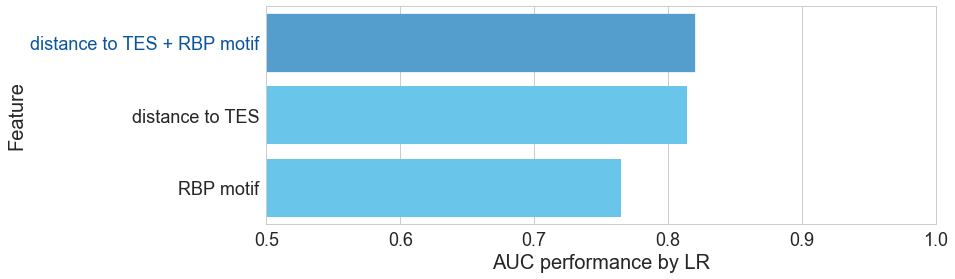

In [13]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,4))
ax = sns.barplot(boxplot_mean_df, boxplot_mean_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by LR', fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel('Feature', fontsize=20)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

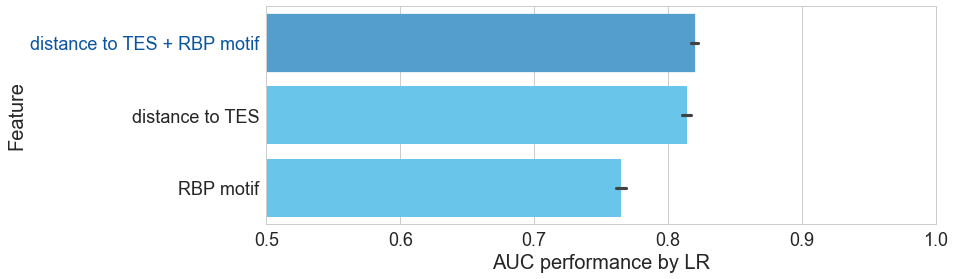

In [14]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

boxplot_errorbar_df = boxplot_df.set_index('feature')[['test auc']]
boxplot_errorbar_df['mean'] = boxplot_df.groupby('feature')['test auc'].mean()
boxplot_errorbar_df.sort_values(by='mean', ascending=False, inplace=True)
boxplot_errorbar_df = boxplot_errorbar_df['test auc']

plt.figure(figsize=(12,4))
ax = sns.barplot(boxplot_errorbar_df, boxplot_errorbar_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by LR', fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel('Feature', fontsize=20)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

In [23]:
boxplot_tuple = []
for feature in ['ss', 'motif']:
    for auc in auc_dict[feature]:
        boxplot_tuple.append((legend_dict[feature], auc))

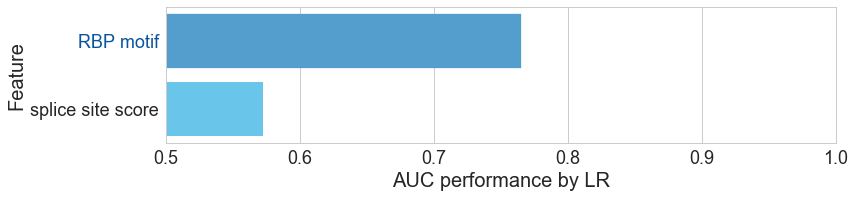

In [24]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,2.5))
ax = sns.barplot(boxplot_mean_df, boxplot_mean_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by LR', fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel('Feature', fontsize=20)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

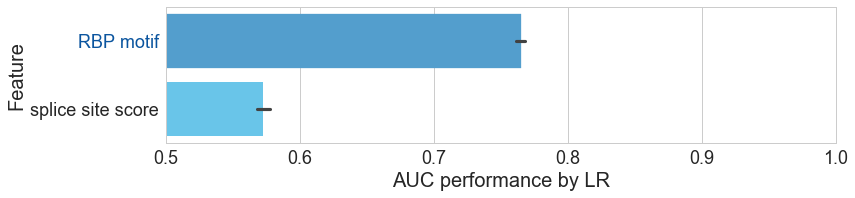

In [25]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

boxplot_errorbar_df = boxplot_df.set_index('feature')[['test auc']]
boxplot_errorbar_df['mean'] = boxplot_df.groupby('feature')['test auc'].mean()
boxplot_errorbar_df.sort_values(by='mean', ascending=False, inplace=True)
boxplot_errorbar_df = boxplot_errorbar_df['test auc']

plt.figure(figsize=(12,2.5))
ax = sns.barplot(boxplot_errorbar_df, boxplot_errorbar_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by LR', fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel('Feature', fontsize=20)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

## length

In [4]:
PATH_FOLDER='/mnt/d/bioproject/IR/scripts_results/zz_results'
data_path = PATH_FOLDER + '/Human_summary/IRI/introns/'

#rest_intron_IRI_df = pd.read_csv('data/Human_summary/IRI/introns/Rest_CD4.quant.IRI.introns.txt', header=0, sep='\t', na_values=['NA', "NA (5'AS)", "NA (3'AS)", "NA (unannotated exon)"])
rest_intron_IRI_df = pd.read_csv( PATH_FOLDER+'/Human_summary/IRI/introns/Naive_Rest_CD8.quant.IRI.introns.txt', header=0, sep='\t', na_values=['NA', "NA (5'AS)", "NA (3'AS)", "NA (unannotated exon)"])
rest_intron_IRI_df = rest_intron_IRI_df[(rest_intron_IRI_df.intron_IRI >= 0) & (rest_intron_IRI_df.intron_IRI <= 1) & (rest_intron_IRI_df.adjacent_CER_RPKM >= 0.1)].loc[:,['CIR_id', 'intron_IRI']]

#active_intron_IRI_df = pd.read_csv('data/Human_summary/IRI/introns/Active_CD4.quant.IRI.introns.txt', header=0, sep='\t', na_values=['NA', "NA (5'AS)", "NA (3'AS)", "NA (unannotated exon)"])
active_intron_IRI_df = pd.read_csv(PATH_FOLDER+'/Human_summary/IRI/introns/Naive_Active_CD8.quant.IRI.introns.txt', header=0, sep='\t', na_values=['NA', "NA (5'AS)", "NA (3'AS)", "NA (unannotated exon)"])
active_intron_IRI_df = active_intron_IRI_df[(active_intron_IRI_df.intron_IRI >= 0) & (active_intron_IRI_df.intron_IRI <= 1) & (active_intron_IRI_df.adjacent_CER_RPKM >= 0.1)].loc[:,['CIR_id', 'intron_IRI']]

In [5]:
distance_df = pd.read_csv(PATH_FOLDER+'/ML_code/data/IRstat.distance_to_TES.introns.txt', header=0, sep='\t')
distance_df['distance_to_TES'] = distance_df['distance_to_TES'] / 1000

In [6]:
rest_plot_df = rest_intron_IRI_df.merge(distance_df, on='CIR_id').dropna()

rest_plot_df.sort_values(by='distance_to_TES', inplace=True)
num_bins = 40
rest_plot_df['distance_to_TES_bin'] = reduce(lambda x, (i, y): x + [i] * len(y), enumerate(np.array_split(range(rest_plot_df.shape[0]), num_bins)), [])

rest_group_plot_df = rest_plot_df.groupby('distance_to_TES_bin')[['distance_to_TES', 'intron_IRI']].mean()

In [7]:
active_plot_df = active_intron_IRI_df.merge(distance_df, on='CIR_id').dropna()

active_plot_df.sort_values(by='distance_to_TES', inplace=True)
num_bins = 40
active_plot_df['distance_to_TES_bin'] = reduce(lambda x, (i, y): x + [i] * len(y), enumerate(np.array_split(range(active_plot_df.shape[0]), num_bins)), [])

active_group_plot_df = active_plot_df.groupby('distance_to_TES_bin')[['distance_to_TES', 'intron_IRI']].mean()

In [8]:
rest_group_plot_df.to_csv('Resting_Group_IRI_To_D_TES.txt', sep='\t')
active_group_plot_df.to_csv('Activated_Group_IRI_To_D_TES.txt', sep='\t')

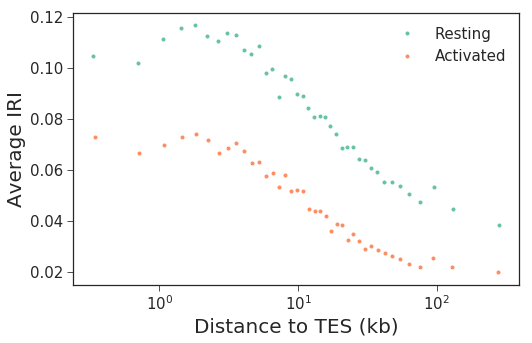

In [103]:
sns.set_style('ticks')
sns.set_palette(sns.color_palette("Set2", 2))
plt.figure(figsize=(8,5))
plt.plot(rest_group_plot_df['distance_to_TES'], rest_group_plot_df['intron_IRI'], '.')
plt.plot(active_group_plot_df['distance_to_TES'], active_group_plot_df['intron_IRI'], '.')
plt.xscale('log')
#plt.ylim(0.9, 1)
plt.minorticks_off()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Distance to TES (kb)', fontsize=20)
plt.ylabel('Average IRI', fontsize=20)
plt.legend(['Resting', 'Activated'], fontsize=15)

In [67]:
### Validation of Previous Results

for i in range(num_bins):
    #print len(active_plot_df[active_plot_df['distance_to_TES_bin']==i])
    #active_plot_df[active_plot_df['distance_to_TES_bin']==i]
    print i+1
    print active_plot_df[active_plot_df['distance_to_TES_bin']==i]['distance_to_TES'].mean()
    print active_plot_df[active_plot_df['distance_to_TES_bin']==i]['intron_IRI'].mean()
    

1
0.341903720752
0.0726732329401
2
0.711012658228
0.0664002950752
3
1.07574376678
0.069703915774
4
1.45720905255
0.0729919139759
5
1.84438856924
0.0739860783446
6
2.2528385117
0.0715472415434
7
2.67224741082
0.0664838618862
8
3.11800652091
0.0686673525608
9
3.59227080936
0.0704625277802
10
4.09466781741
0.0671756617441
11
4.65094859992
0.0626091054937
12
5.25262025316
0.0629051137348
13
5.88994438051
0.0574026292725
14
6.57378059072
0.0586176519997
15
7.30349175297
0.0532163209106
16
8.08061756809
0.0580205450172
17
8.93736018412
0.0516309684959
18
9.88512773303
0.0520842384851
19
10.9110993479
0.0518547022158
20
11.9988166475
0.0446140829515
21
13.1623778289
0.0438619565892
22
14.4272347526
0.0439528152621
23
15.8046052934
0.0420634155178
24
17.3087614116
0.0360136640627
25
18.9812232451
0.0389609536284
26
20.763668201
0.0385620125539
27
22.7646555428
0.0325404401741
28
25.0524322977
0.0349169556221
29
27.5991692249
0.0319877042831
30
30.4690629317
0.0291803846399
31
33.702813891
0.03

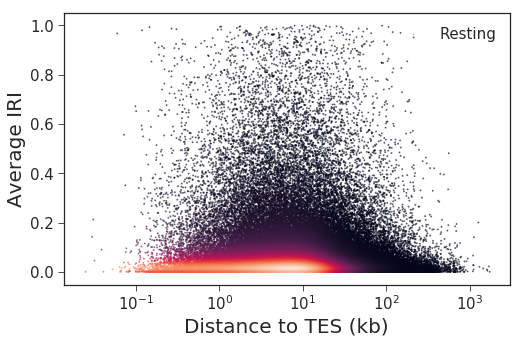

In [130]:
from scipy.stats import gaussian_kde
### Validation of Previous Results
#rest_intron_IRI_df
#active_intron_IRI_df
#distance_df
#distance_df['distance_to_TES']
sns.set_style('ticks')
sns.set_palette(sns.color_palette("Set2", 2))
plt.figure(figsize=(8,5))


# Calculate the point density
#xy = np.vstack([active_plot_df['distance_to_TES'], active_plot_df['intron_IRI']])
#xy = np.vstack([rest_plot_df['distance_to_TES'], rest_plot_df['intron_IRI']])
#z = gaussian_kde(xy)(xy)

#plt.plot(rest_plot_df['distance_to_TES'].iloc[:], rest_plot_df['intron_IRI'].iloc[:], '.', markersize=1, alpha=1, label='Resting')
#plt.plot(active_plot_df['distance_to_TES'].iloc[:], active_plot_df['intron_IRI'].iloc[:], '.', markersize=1, alpha=0.5, label='Activated') 

plt.scatter(rest_plot_df['distance_to_TES'].iloc[:], rest_plot_df['intron_IRI'].iloc[:], s=1, alpha=0.5,c=z, label='Resting')
#plt.scatter(active_plot_df['distance_to_TES'].iloc[:], active_plot_df['intron_IRI'].iloc[:], s=1,alpha=0.5, c=z, label='Activated')

plt.xscale('log')
#plt.ylim(0.0, 1.0)
#plt.xlim(0.01, 1500)
plt.minorticks_off()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Distance to TES (kb)', fontsize=20)
plt.ylabel('Average IRI', fontsize=20)
plt.legend( markerscale=1, fontsize=15)

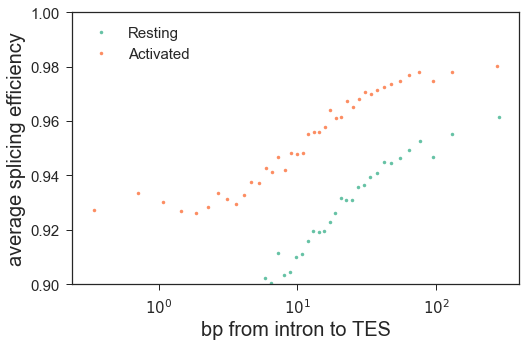

In [10]:
sns.set_style('ticks')
sns.set_palette(sns.color_palette("Set2", 2))
plt.figure(figsize=(8,5))
plt.plot(rest_group_plot_df['distance_to_TES'], 1-rest_group_plot_df['intron_IRI'], '.')
plt.plot(active_group_plot_df['distance_to_TES'], 1-active_group_plot_df['intron_IRI'], '.')
plt.xscale('log')
plt.ylim(0.9, 1)
plt.minorticks_off()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('bp from intron to TES', fontsize=20)
plt.ylabel('average splicing efficiency', fontsize=20)
plt.legend(['Resting', 'Activated'], fontsize=15)

### remove last intron

In [11]:
gene_num_CIR_dict = {}
simple_gene_list = []
gtffile = HTSeq.GFF_Reader('/Users/zzeng/Desktop/quick_visit/gtf_files/hg19_IR_annotation.gtf')
for feature in gtffile:
    if feature.type == 'gene_region':
        gene_id = feature.attr['gene_id']
        gene_num_CIR_dict[gene_id] = int(feature.attr['constitutive_intronic_region_number'])
        if int(feature.attr['transcripts_in_gene']) == 1:
            simple_gene_list.append(feature.attr['gene_id'])

In [12]:
rest_intron_IRI_df['gene_id'] = rest_intron_IRI_df.CIR_id.str[:-4]
rest_intron_IRI_df['num_CIR'] = rest_intron_IRI_df.CIR_id.str[-3:].astype(int)
rest_intron_IRI_df['is_last_intron'] = rest_intron_IRI_df.apply(lambda row: gene_num_CIR_dict[row['gene_id']] == row['num_CIR'], axis=1)
rest_intron_IRI_df['is_first_intron'] = rest_intron_IRI_df.apply(lambda row: 1 == row['num_CIR'], axis=1)

In [13]:
active_intron_IRI_df['gene_id'] = active_intron_IRI_df.CIR_id.str[:-4]
active_intron_IRI_df['num_CIR'] = active_intron_IRI_df.CIR_id.str[-3:].astype(int)
active_intron_IRI_df['is_last_intron'] = active_intron_IRI_df.apply(lambda row: gene_num_CIR_dict[row['gene_id']] == row['num_CIR'], axis=1)
active_intron_IRI_df['is_first_intron'] = active_intron_IRI_df.apply(lambda row: 1 == row['num_CIR'], axis=1)

In [14]:
rest_plot_df = rest_intron_IRI_df[~rest_intron_IRI_df['is_last_intron']].merge(distance_df, on='CIR_id').dropna()

rest_plot_df.sort_values(by='distance_to_TES', inplace=True)
num_bins = 40
rest_plot_df['distance_to_TES_bin'] = reduce(lambda x, (i, y): x + [i] * len(y), enumerate(np.array_split(range(rest_plot_df.shape[0]), num_bins)), [])

rest_group_plot_df = rest_plot_df.groupby('distance_to_TES_bin')[['distance_to_TES', 'intron_IRI']].mean()

In [15]:
active_plot_df = active_intron_IRI_df[~active_intron_IRI_df['is_last_intron']].merge(distance_df, on='CIR_id').dropna()

active_plot_df.sort_values(by='distance_to_TES', inplace=True)
num_bins = 40
active_plot_df['distance_to_TES_bin'] = reduce(lambda x, (i, y): x + [i] * len(y), enumerate(np.array_split(range(active_plot_df.shape[0]), num_bins)), [])

active_group_plot_df = active_plot_df.groupby('distance_to_TES_bin')[['distance_to_TES', 'intron_IRI']].mean()

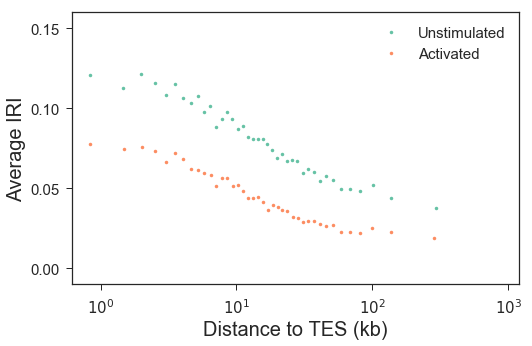

In [16]:
sns.set_style('ticks')
sns.set_palette(sns.color_palette("Set2", 2))
plt.figure(figsize=(8,5))
ax = plt.gca()
ax.locator_params(nbins=5, axis='y')
plt.plot(rest_group_plot_df['distance_to_TES'], rest_group_plot_df['intron_IRI'], '.')
plt.plot(active_group_plot_df['distance_to_TES'], active_group_plot_df['intron_IRI'], '.')
plt.xscale('log')
#plt.ylim(0.9, 1)
plt.minorticks_off()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([None, 1200])
plt.ylim([-0.01, 0.16])
plt.xlabel('Distance to TES (kb)', fontsize=20)
plt.ylabel('Average IRI', fontsize=20)
#plt.legend(['Resting', 'Activated'], fontsize=15)
plt.legend(['Unstimulated', 'Activated'], fontsize=15)

### remove both first and last intron

In [193]:
rest_plot_df = rest_intron_IRI_df[(~rest_intron_IRI_df['is_last_intron']) & (~rest_intron_IRI_df['is_first_intron'])].merge(distance_df, on='CIR_id').dropna()

rest_plot_df.sort_values(by='distance_to_TES', inplace=True)
num_bins = 40
rest_plot_df['distance_to_TES_bin'] = reduce(lambda x, (i, y): x + [i] * len(y), enumerate(np.array_split(range(rest_plot_df.shape[0]), num_bins)), [])

rest_group_plot_df = rest_plot_df.groupby('distance_to_TES_bin')[['distance_to_TES', 'intron_IRI']].mean()

In [194]:
active_plot_df = active_intron_IRI_df[(~active_intron_IRI_df['is_last_intron']) & (~active_intron_IRI_df['is_first_intron'])].merge(distance_df, on='CIR_id').dropna()

active_plot_df.sort_values(by='distance_to_TES', inplace=True)
num_bins = 40
active_plot_df['distance_to_TES_bin'] = reduce(lambda x, (i, y): x + [i] * len(y), enumerate(np.array_split(range(active_plot_df.shape[0]), num_bins)), [])

active_group_plot_df = active_plot_df.groupby('distance_to_TES_bin')[['distance_to_TES', 'intron_IRI']].mean()

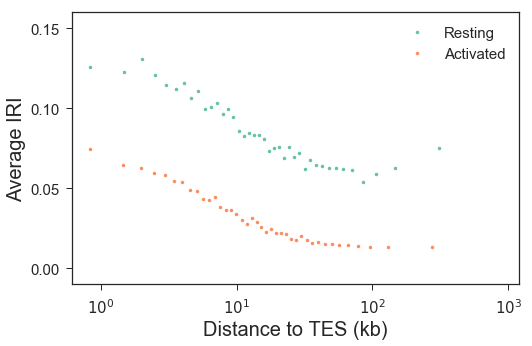

In [195]:
sns.set_style('ticks')
sns.set_palette(sns.color_palette("Set2", 2))
plt.figure(figsize=(8,5))
ax = plt.gca()
ax.locator_params(nbins=5, axis='y')
plt.plot(rest_group_plot_df['distance_to_TES'], rest_group_plot_df['intron_IRI'], '.')
plt.plot(active_group_plot_df['distance_to_TES'], active_group_plot_df['intron_IRI'], '.')
plt.xscale('log')
#plt.ylim(0.9, 1)
plt.minorticks_off()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([None, 1200])
plt.ylim([-0.01, 0.16])
plt.xlabel('Distance to TES (kb)', fontsize=20)
plt.ylabel('Average IRI', fontsize=20)
plt.legend(['Resting', 'Activated'], fontsize=15)

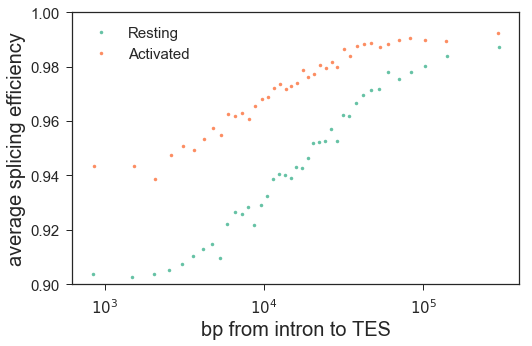

In [179]:
sns.set_style('ticks')
sns.set_palette(sns.color_palette("Set2", 2))
plt.figure(figsize=(8,5))
plt.plot(rest_group_plot_df['distance_to_TES'], 1-rest_group_plot_df['intron_IRI'], '.')
plt.plot(active_group_plot_df['distance_to_TES'], 1-active_group_plot_df['intron_IRI'], '.')
plt.xscale('log')
plt.ylim(0.9, 1)
plt.minorticks_off()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('bp from intron to TES', fontsize=20)
plt.ylabel('average splicing efficiency', fontsize=20)
plt.legend(['Resting', 'Activated'], fontsize=15)

In [ ]:
rest_group_plot_df = rest_plot_df.groupby('distance_to_TES_bin').agg({'distance_to_TES': 'mean', 'intron_IRI': ['mean', 'std']})
rest_group_plot_df.columns = ['_'.join(x) for x in rest_group_plot_df.columns.tolist()]

In [210]:
active_group_plot_df = active_plot_df.groupby('distance_to_TES_bin').agg({'distance_to_TES': 'mean', 'intron_IRI': ['mean', 'std']})
active_group_plot_df.columns = ['_'.join(x) for x in active_group_plot_df.columns.tolist()]

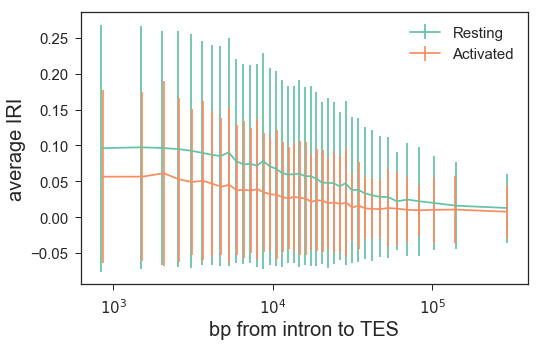

In [216]:
sns.set_style('ticks')
sns.set_palette(sns.color_palette("Set2", 2))
plt.figure(figsize=(8,5))
plt.errorbar(rest_group_plot_df['distance_to_TES_mean'], rest_group_plot_df['intron_IRI_mean'], yerr=rest_group_plot_df['intron_IRI_std'])
plt.errorbar(active_group_plot_df['distance_to_TES_mean'], active_group_plot_df['intron_IRI_mean'], yerr=active_group_plot_df['intron_IRI_std'])
plt.xscale('log')
#plt.ylim(0.9, 1)
plt.minorticks_off()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('bp from intron to TES', fontsize=20)
plt.ylabel('average IRI', fontsize=20)
plt.legend(['Resting', 'Activated'], fontsize=15)

### simple genes

In [8]:
rest_intron_IRI_df['gene_id'] = rest_intron_IRI_df.CIR_id.str[:-4]
rest_intron_IRI_df['num_CIR'] = rest_intron_IRI_df.CIR_id.str[-3:].astype(int)
rest_intron_IRI_df['is_last_intron'] = rest_intron_IRI_df.apply(lambda row: gene_num_CIR_dict[row['gene_id']] == row['num_CIR'], axis=1)
rest_intron_IRI_df['is_simple_gene'] = rest_intron_IRI_df.apply(lambda row: row['gene_id'] in simple_gene_list, axis=1)

In [9]:
active_intron_IRI_df['gene_id'] = active_intron_IRI_df.CIR_id.str[:-4]
active_intron_IRI_df['num_CIR'] = active_intron_IRI_df.CIR_id.str[-3:].astype(int)
active_intron_IRI_df['is_last_intron'] = active_intron_IRI_df.apply(lambda row: gene_num_CIR_dict[row['gene_id']] == row['num_CIR'], axis=1)
active_intron_IRI_df['is_simple_gene'] = active_intron_IRI_df.apply(lambda row: row['gene_id'] in simple_gene_list, axis=1)

In [12]:
rest_plot_df = rest_intron_IRI_df[~rest_intron_IRI_df['is_last_intron'] & rest_intron_IRI_df['is_simple_gene']].merge(distance_df, on='CIR_id').dropna()

rest_plot_df.sort_values(by='distance_to_TES', inplace=True)
num_bins = 40
rest_plot_df['distance_to_TES_bin'] = reduce(lambda x, (i, y): x + [i] * len(y), enumerate(np.array_split(range(rest_plot_df.shape[0]), num_bins)), [])

rest_group_plot_df = rest_plot_df.groupby('distance_to_TES_bin')[['distance_to_TES', 'intron_IRI']].mean()

In [13]:
active_plot_df = active_intron_IRI_df[~active_intron_IRI_df['is_last_intron'] & active_intron_IRI_df['is_simple_gene']].merge(distance_df, on='CIR_id').dropna()

active_plot_df.sort_values(by='distance_to_TES', inplace=True)
num_bins = 40
active_plot_df['distance_to_TES_bin'] = reduce(lambda x, (i, y): x + [i] * len(y), enumerate(np.array_split(range(active_plot_df.shape[0]), num_bins)), [])

active_group_plot_df = active_plot_df.groupby('distance_to_TES_bin')[['distance_to_TES', 'intron_IRI']].mean()

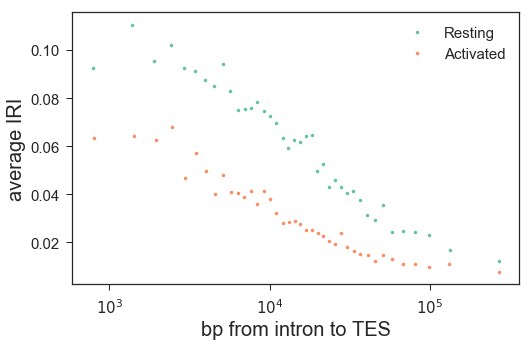

In [14]:
sns.set_style('ticks')
sns.set_palette(sns.color_palette("Set2", 2))
plt.figure(figsize=(8,5))
plt.plot(rest_group_plot_df['distance_to_TES'], rest_group_plot_df['intron_IRI'], '.')
plt.plot(active_group_plot_df['distance_to_TES'], active_group_plot_df['intron_IRI'], '.')
plt.xscale('log')
#plt.ylim(0.9, 1)
plt.minorticks_off()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('bp from intron to TES', fontsize=20)
plt.ylabel('average IRI', fontsize=20)
plt.legend(['Resting', 'Activated'], fontsize=15)

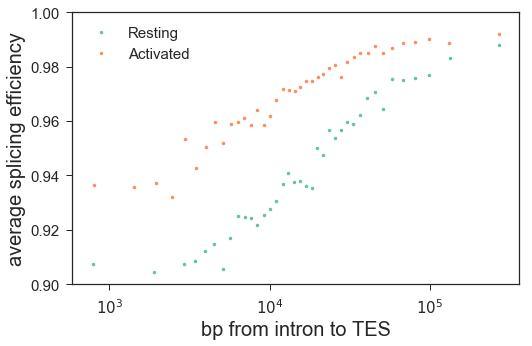

In [15]:
sns.set_style('ticks')
sns.set_palette(sns.color_palette("Set2", 2))
plt.figure(figsize=(8,5))
plt.plot(rest_group_plot_df['distance_to_TES'], 1-rest_group_plot_df['intron_IRI'], '.')
plt.plot(active_group_plot_df['distance_to_TES'], 1-active_group_plot_df['intron_IRI'], '.')
plt.xscale('log')
plt.ylim(0.9, 1)
plt.minorticks_off()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('bp from intron to TES', fontsize=20)
plt.ylabel('average splicing efficiency', fontsize=20)
plt.legend(['Resting', 'Activated'], fontsize=15)

### IRI associated with distance to TES in all mouse

In [17]:
data_list = ['macrophage', 'DC', 'ILC', 'B', 'CD4', 'CD8']

os.chdir('/Users/zzeng/Documents/GitHub/ML_code/core_circuit')
data_path = 'data/Mus_summary/IRI/introns/'

In [18]:
data_dict = {'B_Rest': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'B_0h', x), os.listdir(data_path))],
             'B_Active': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'B_24h', x), os.listdir(data_path))],
             'CD4_Rest': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'NIV_0h', x), os.listdir(data_path))],
             'CD4_Active': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'Th1_24h', x), os.listdir(data_path))],
             #'CD8_Rest': ['data/Human_summary/IRI/Naive_Rest_CD8.quant.IRI.genes.txt'],
             #'CD8_Active': ['data/Human_summary/IRI/Naive_Active_CD8.quant.IRI.genes.txt'],
             #'CD8_Rest': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'CD8_Rest', x), os.listdir(data_path))],
             #'CD8_Active': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'CD8_Active', x), os.listdir(data_path))],
             'CD8_Rest': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'Naive\d_CD8', x), os.listdir(data_path))],
             'CD8_Active': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'Active\d_CD8_Day4', x), os.listdir(data_path))],
             'DC_Rest': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'DC_Unstimulated', x), os.listdir(data_path))],
             'DC_Active': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'DC_LPS_6h', x), os.listdir(data_path))],
             'macrophage_Rest': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'UT_macrophage', x), os.listdir(data_path))],
             'macrophage_Active': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'IL4_4h_macrophage', x), os.listdir(data_path))],
             'ILC_Rest': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'Rest_NK', x), os.listdir(data_path))],
             'ILC_Active': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'Active_NK', x), os.listdir(data_path))]}
             #'ILC_Rest': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'Rest_ILC2', x), os.listdir(data_path))],
             #'ILC_Active': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'Active_ILC2', x), os.listdir(data_path))]}

In [19]:
distance_df = pd.read_csv('/Users/zzeng/Documents/GitHub/ML_code/data/IRstat.Mouse.distance_to_TES.introns.txt', header=0, sep='\t')
distance_df['distance_to_TES'] = distance_df['distance_to_TES'] / 1000

In [20]:
df_dict = {}

for sample in data_list:
    name = sample+'_Rest'
    Rest_rep_df_list = []
    for i, data_full_path in enumerate(data_dict[name]):
        Rest_rep_df = pd.read_csv(data_full_path, header=0, sep='\t', na_values=['NA', "NA (5'AS)", "NA (3'AS)", "NA (unannotated exon)"]).loc[:,['CIR_id', 'intron_IRI', 'adjacent_CER_RPKM']]
        Rest_rep_df = Rest_rep_df[(Rest_rep_df.intron_IRI >= 0) & (Rest_rep_df.intron_IRI <= 1) & (Rest_rep_df.adjacent_CER_RPKM >= 0.1)].drop(labels=['adjacent_CER_RPKM'], axis=1).rename(columns={'intron_IRI': '{}_Rep{}_IRI'.format(name, i+1)})
        Rest_rep_df.set_index('CIR_id', inplace=True)
        Rest_rep_df_list.append(Rest_rep_df)
    Rest_df = pd.concat(Rest_rep_df_list, axis=1).dropna()
    Rest_df[name+'_IRI'] = Rest_df.apply(lambda row: np.mean(row[:]), axis=1)
    Rest_df = Rest_df.loc[:,[name+'_IRI']]
    
    name = sample+'_Active'
    Active_rep_df_list = []
    for i, data_full_path in enumerate(data_dict[name]):
        Active_rep_df = pd.read_csv(data_full_path, header=0, sep='\t', na_values=['NA', "NA (5'AS)", "NA (3'AS)", "NA (unannotated exon)"]).loc[:,['CIR_id', 'intron_IRI', 'adjacent_CER_RPKM']]
        Active_rep_df = Active_rep_df[(Active_rep_df.intron_IRI >= 0) & (Active_rep_df.intron_IRI <= 1) & (Active_rep_df.adjacent_CER_RPKM >= 1)].drop(labels=['adjacent_CER_RPKM'], axis=1).rename(columns={'intron_IRI': '{}_Rep{}_IRI'.format(name, i+1)})
        Active_rep_df.set_index('CIR_id', inplace=True)
        Active_rep_df_list.append(Active_rep_df)
    Active_df = pd.concat(Active_rep_df_list, axis=1).dropna()
    Active_df[name+'_IRI'] = Active_df.apply(lambda row: np.mean(row[:]), axis=1)
    Active_df = Active_df.loc[:,[name+'_IRI']]
    
    df_dict[sample+'_Rest'] = Rest_df
    df_dict[sample+'_Active'] = Active_df

In [21]:
num_bins = 40
group_plot_df_dict = {}
for i, sample in enumerate(data_list):
    rest_plot_df = df_dict[sample+'_Rest'].reset_index().rename(columns={'index': 'CIR_id', sample+'_Rest_IRI': 'intron_IRI'}).merge(distance_df, on='CIR_id').dropna()

    rest_plot_df.sort_values(by='distance_to_TES', inplace=True)
    rest_plot_df['distance_to_TES_bin'] = reduce(lambda x, (i, y): x + [i] * len(y), enumerate(np.array_split(range(rest_plot_df.shape[0]), num_bins)), [])

    rest_group_plot_df = rest_plot_df.groupby('distance_to_TES_bin')[['distance_to_TES', 'intron_IRI']].mean()
    
    active_plot_df = df_dict[sample+'_Active'].reset_index().rename(columns={'index': 'CIR_id', sample+'_Active_IRI': 'intron_IRI'}).merge(distance_df, on='CIR_id').dropna()

    active_plot_df.sort_values(by='distance_to_TES', inplace=True)
    active_plot_df['distance_to_TES_bin'] = reduce(lambda x, (i, y): x + [i] * len(y), enumerate(np.array_split(range(active_plot_df.shape[0]), num_bins)), [])

    active_group_plot_df = active_plot_df.groupby('distance_to_TES_bin')[['distance_to_TES', 'intron_IRI']].mean()
    
    group_plot_df_dict[sample+'_Rest'] = rest_group_plot_df
    group_plot_df_dict[sample+'_Active'] = active_group_plot_df

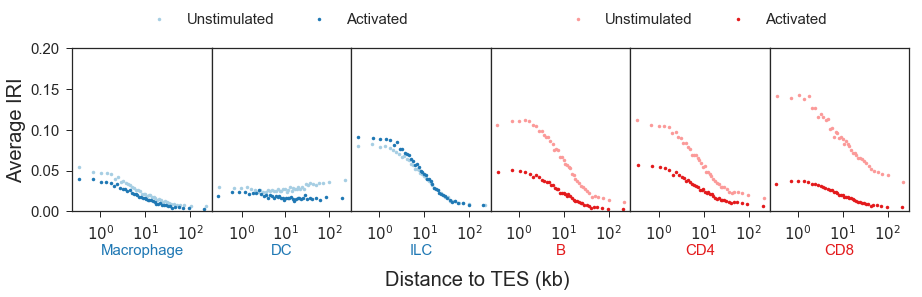

In [22]:
title_dict = {'macrophage': 'Macrophage', 
              'DC': 'DC',
              'ILC': 'ILC',
              'B': 'B',
              'CD4': 'CD4',
              'CD8': 'CD8'}

num_bins = 40
num_all = len(data_list)
num_innate = 3
plt.subplots(nrows=1,ncols=num_all, figsize=(15,3))
plt.subplots_adjust(wspace=0)
for i, sample in enumerate(data_list):
    if i < num_innate:
        sns.set_palette(sns.color_palette("Paired")[:2]) 
        color1, color2 = sns.color_palette("Paired")[:2]
    else:
        sns.set_palette(sns.color_palette("Paired")[4:6]) 
        color1, color2 = sns.color_palette("Paired")[4:6]
        
    ax = plt.subplot(1,num_all, i+1)
    ax.locator_params(nbins=5, axis='y')
    
    rest_group_plot_df, active_group_plot_df = group_plot_df_dict[sample+'_Rest'], group_plot_df_dict[sample+'_Active']
    
    plt.plot(rest_group_plot_df['distance_to_TES'], rest_group_plot_df['intron_IRI'], '.')
    plt.plot(active_group_plot_df['distance_to_TES'], active_group_plot_df['intron_IRI'], '.')
    plt.xscale('log')
    plt.ylim(0, 0.2)
    plt.minorticks_off()
    plt.xticks(fontsize=15)
    if i == 0:
        plt.ylabel('Average IRI', fontsize=20)
        plt.yticks(size=15)
    else:
        plt.yticks([])
        
    if i == 0 or i == num_innate:
        #plt.legend(['resting','activated'], ncol=2, fontsize=15)
        #plt.legend(['resting','activated'], ncol=2, fontsize=15, bbox_to_anchor=(2.6, 1.5))
        #plt.legend(['Resting','Activated'], ncol=2, fontsize=15, bbox_to_anchor=(2.5, 1.3))
        plt.legend(['Unstimulated','Activated'], ncol=2, fontsize=15, bbox_to_anchor=(2.5, 1.3))
        leg = ax.get_legend()
        leg.legendHandles[0].set_color(color1)
        leg.legendHandles[1].set_color(color2)
#         leg.texts[0].set_color(color1)
#         leg.texts[1].set_color(color2)
    else:
        plt.legend([])
        
    if i < num_innate:
        plt.title(title_dict[sample], y=-0.3, fontsize=15, color=sns.color_palette("Paired")[1])
    else:
        plt.title(title_dict[sample], y=-0.3, fontsize=15, color=sns.color_palette("Paired")[5])
        
plt.suptitle('Distance to TES (kb)', y=-0.15, fontsize=20)

#### remove last intron

In [23]:
gene_num_CIR_dict = {}
simple_gene_list = []
gtffile = HTSeq.GFF_Reader('/Users/zzeng/Desktop/quick_visit/gtf_files/mm9_IR_annotation.gtf')
for feature in gtffile:
    if feature.type == 'gene_region':
        gene_id = feature.attr['gene_id']
        gene_num_CIR_dict[gene_id] = int(feature.attr['constitutive_intronic_region_number'])
        if int(feature.attr['transcripts_in_gene']) == 1:
            simple_gene_list.append(feature.attr['gene_id'])

In [24]:
df_dict = {}

for sample in data_list:
    name = sample+'_Rest'
    Rest_rep_df_list = []
    for i, data_full_path in enumerate(data_dict[name]):
        Rest_rep_df = pd.read_csv(data_full_path, header=0, sep='\t', na_values=['NA', "NA (5'AS)", "NA (3'AS)", "NA (unannotated exon)"]).loc[:,['CIR_id', 'intron_IRI', 'adjacent_CER_RPKM']]
        Rest_rep_df = Rest_rep_df[(Rest_rep_df.intron_IRI >= 0) & (Rest_rep_df.intron_IRI <= 1) & (Rest_rep_df.adjacent_CER_RPKM >= 0.1)].drop(labels=['adjacent_CER_RPKM'], axis=1).rename(columns={'intron_IRI': '{}_Rep{}_IRI'.format(name, i+1)})
        Rest_rep_df.set_index('CIR_id', inplace=True)
        Rest_rep_df_list.append(Rest_rep_df)
    Rest_df = pd.concat(Rest_rep_df_list, axis=1).dropna()
    Rest_df[name+'_IRI'] = Rest_df.apply(lambda row: np.mean(row[:]), axis=1)
    Rest_df = Rest_df.loc[:,[name+'_IRI']]
    
    Rest_df['gene_id'] = Rest_df.index.str[:-4]
    Rest_df['num_CIR'] = Rest_df.index.str[-3:].astype(int)
    Rest_df['is_last_intron'] = Rest_df.apply(lambda row: gene_num_CIR_dict[row['gene_id']] == row['num_CIR'], axis=1)
    
    name = sample+'_Active'
    Active_rep_df_list = []
    for i, data_full_path in enumerate(data_dict[name]):
        Active_rep_df = pd.read_csv(data_full_path, header=0, sep='\t', na_values=['NA', "NA (5'AS)", "NA (3'AS)", "NA (unannotated exon)"]).loc[:,['CIR_id', 'intron_IRI', 'adjacent_CER_RPKM']]
        Active_rep_df = Active_rep_df[(Active_rep_df.intron_IRI >= 0) & (Active_rep_df.intron_IRI <= 1) & (Active_rep_df.adjacent_CER_RPKM >= 1)].drop(labels=['adjacent_CER_RPKM'], axis=1).rename(columns={'intron_IRI': '{}_Rep{}_IRI'.format(name, i+1)})
        Active_rep_df.set_index('CIR_id', inplace=True)
        Active_rep_df_list.append(Active_rep_df)
    Active_df = pd.concat(Active_rep_df_list, axis=1).dropna()
    Active_df[name+'_IRI'] = Active_df.apply(lambda row: np.mean(row[:]), axis=1)
    Active_df = Active_df.loc[:,[name+'_IRI']]
    
    Active_df['gene_id'] = Active_df.index.str[:-4]
    Active_df['num_CIR'] = Active_df.index.str[-3:].astype(int)
    Active_df['is_last_intron'] = Active_df.apply(lambda row: gene_num_CIR_dict[row['gene_id']] == row['num_CIR'], axis=1)
    
    df_dict[sample+'_Rest'] = Rest_df
    df_dict[sample+'_Active'] = Active_df

In [25]:
num_bins = 40
group_plot_df_dict = {}
for i, sample in enumerate(data_list):
    rest_intron_IRI_df = df_dict[sample+'_Rest'].reset_index().rename(columns={'index': 'CIR_id', sample+'_Rest_IRI': 'intron_IRI'})
    rest_plot_df = rest_intron_IRI_df[~rest_intron_IRI_df['is_last_intron']].merge(distance_df, on='CIR_id').dropna()

    rest_plot_df.sort_values(by='distance_to_TES', inplace=True)
    rest_plot_df['distance_to_TES_bin'] = reduce(lambda x, (i, y): x + [i] * len(y), enumerate(np.array_split(range(rest_plot_df.shape[0]), num_bins)), [])

    rest_group_plot_df = rest_plot_df.groupby('distance_to_TES_bin')[['distance_to_TES', 'intron_IRI']].mean()
    
    active_intron_IRI_df = df_dict[sample+'_Active'].reset_index().rename(columns={'index': 'CIR_id', sample+'_Active_IRI': 'intron_IRI'})
    active_plot_df = active_intron_IRI_df[~active_intron_IRI_df['is_last_intron']].merge(distance_df, on='CIR_id').dropna()

    active_plot_df.sort_values(by='distance_to_TES', inplace=True)
    active_plot_df['distance_to_TES_bin'] = reduce(lambda x, (i, y): x + [i] * len(y), enumerate(np.array_split(range(active_plot_df.shape[0]), num_bins)), [])

    active_group_plot_df = active_plot_df.groupby('distance_to_TES_bin')[['distance_to_TES', 'intron_IRI']].mean()
    
    group_plot_df_dict[sample+'_Rest'] = rest_group_plot_df
    group_plot_df_dict[sample+'_Active'] = active_group_plot_df

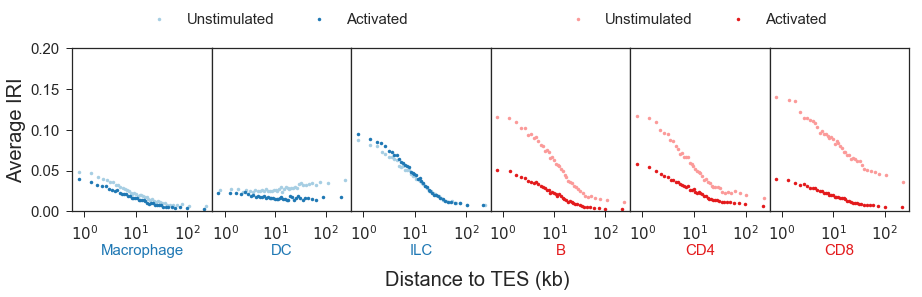

In [26]:
title_dict = {'macrophage': 'Macrophage', 
              'DC': 'DC',
              'ILC': 'ILC',
              'B': 'B',
              'CD4': 'CD4',
              'CD8': 'CD8'}

num_bins = 40
num_all = len(data_list)
num_innate = 3
plt.subplots(nrows=1,ncols=num_all, figsize=(15,3))
plt.subplots_adjust(wspace=0)
for i, sample in enumerate(data_list):
    if i < num_innate:
        sns.set_palette(sns.color_palette("Paired")[:2]) 
        color1, color2 = sns.color_palette("Paired")[:2]
    else:
        sns.set_palette(sns.color_palette("Paired")[4:6]) 
        color1, color2 = sns.color_palette("Paired")[4:6]
        
    ax = plt.subplot(1,num_all, i+1)
    ax.locator_params(nbins=5, axis='y')
    
    rest_group_plot_df, active_group_plot_df = group_plot_df_dict[sample+'_Rest'], group_plot_df_dict[sample+'_Active']
    
    plt.plot(rest_group_plot_df['distance_to_TES'], rest_group_plot_df['intron_IRI'], '.')
    plt.plot(active_group_plot_df['distance_to_TES'], active_group_plot_df['intron_IRI'], '.')
    plt.xscale('log')
    plt.ylim(0, 0.2)
    plt.minorticks_off()
    plt.xticks(fontsize=15)
    if i == 0:
        plt.ylabel('Average IRI', fontsize=20)
        plt.yticks(size=15)
    else:
        plt.yticks([])
        
    if i == 0 or i == num_innate:
        #plt.legend(['resting','activated'], ncol=2, fontsize=15)
        #plt.legend(['resting','activated'], ncol=2, fontsize=15, bbox_to_anchor=(2.6, 1.5))
        #plt.legend(['Resting','Activated'], ncol=2, fontsize=15, bbox_to_anchor=(2.5, 1.3))
        plt.legend(['Unstimulated','Activated'], ncol=2, fontsize=15, bbox_to_anchor=(2.5, 1.3))
        leg = ax.get_legend()
        leg.legendHandles[0].set_color(color1)
        leg.legendHandles[1].set_color(color2)
#         leg.texts[0].set_color(color1)
#         leg.texts[1].set_color(color2)
    else:
        plt.legend([])
        
    if i < num_innate:
        plt.title(title_dict[sample], y=-0.3, fontsize=15, color=sns.color_palette("Paired")[1])
    else:
        plt.title(title_dict[sample], y=-0.3, fontsize=15, color=sns.color_palette("Paired")[5])
        
plt.suptitle('Distance to TES (kb)', y=-0.15, fontsize=20)

### IRI associated with distance to TES in all human

In [27]:
data_list = ['Naive_CD4', 'EM_CD4', 'CM_CD4', 'Naive_CD8', 'EM_CD8', 'CM_CD8']


os.chdir('/Users/zzeng/Documents/GitHub/ML_code/core_circuit')
data_path = 'data/Human_summary/IRI/introns/'

In [28]:
data_dict = {'Naive_CD4_Rest': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'Naive_CD4_Rest', x), os.listdir(data_path))],
             'Naive_CD4_Active': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'Naive_CD4_Active_15h', x), os.listdir(data_path))],
             'EM_CD4_Rest': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'TEM_CD4_Rest', x), os.listdir(data_path))],
             'EM_CD4_Active': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'TEM_CD4_Active_15h', x), os.listdir(data_path))],
             'CM_CD4_Rest': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'CM_CD4_Rest', x), os.listdir(data_path))],
             'CM_CD4_Active': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'CM_CD4_Active_15h', x), os.listdir(data_path))],
             'Naive_CD8_Rest': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'Naive_Rest_CD8', x), os.listdir(data_path))],
             'Naive_CD8_Active': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'Naive_Active_CD8', x), os.listdir(data_path))],
             'EM_CD8_Rest': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'EM_Rest_CD8', x), os.listdir(data_path))],
             'EM_CD8_Active': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'EM_Active_CD8', x), os.listdir(data_path))],
             'CM_CD8_Rest': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'CM_Rest_CD8', x), os.listdir(data_path))],
             'CM_CD8_Active': [os.path.join(data_path + x) for x in filter(lambda x: re.search(r'CM_Active_CD8', x), os.listdir(data_path))],}

In [29]:
distance_df = pd.read_csv('/Users/zzeng/Documents/GitHub/ML_code/data/IRstat.distance_to_TES.introns.txt', header=0, sep='\t')
distance_df['distance_to_TES'] = distance_df['distance_to_TES'] / 1000

In [30]:
df_dict = {}

for sample in data_list:
    name = sample+'_Rest'
    Rest_rep_df_list = []
    for i, data_full_path in enumerate(data_dict[name]):
        Rest_rep_df = pd.read_csv(data_full_path, header=0, sep='\t', na_values=['NA', "NA (5'AS)", "NA (3'AS)", "NA (unannotated exon)"]).loc[:,['CIR_id', 'intron_IRI', 'adjacent_CER_RPKM']]
        Rest_rep_df = Rest_rep_df[(Rest_rep_df.intron_IRI >= 0) & (Rest_rep_df.intron_IRI <= 1) & (Rest_rep_df.adjacent_CER_RPKM >= 0.1)].drop(labels=['adjacent_CER_RPKM'], axis=1).rename(columns={'intron_IRI': '{}_Rep{}_IRI'.format(name, i+1)})
        Rest_rep_df.set_index('CIR_id', inplace=True)
        Rest_rep_df_list.append(Rest_rep_df)
    Rest_df = pd.concat(Rest_rep_df_list, axis=1).dropna()
    Rest_df[name+'_IRI'] = Rest_df.apply(lambda row: np.mean(row[:]), axis=1)
    Rest_df = Rest_df.loc[:,[name+'_IRI']]
    
    name = sample+'_Active'
    Active_rep_df_list = []
    for i, data_full_path in enumerate(data_dict[name]):
        Active_rep_df = pd.read_csv(data_full_path, header=0, sep='\t', na_values=['NA', "NA (5'AS)", "NA (3'AS)", "NA (unannotated exon)"]).loc[:,['CIR_id', 'intron_IRI', 'adjacent_CER_RPKM']]
        Active_rep_df = Active_rep_df[(Active_rep_df.intron_IRI >= 0) & (Active_rep_df.intron_IRI <= 1) & (Active_rep_df.adjacent_CER_RPKM >= 1)].drop(labels=['adjacent_CER_RPKM'], axis=1).rename(columns={'intron_IRI': '{}_Rep{}_IRI'.format(name, i+1)})
        Active_rep_df.set_index('CIR_id', inplace=True)
        Active_rep_df_list.append(Active_rep_df)
    Active_df = pd.concat(Active_rep_df_list, axis=1).dropna()
    Active_df[name+'_IRI'] = Active_df.apply(lambda row: np.mean(row[:]), axis=1)
    Active_df = Active_df.loc[:,[name+'_IRI']]
    
    df_dict[sample+'_Rest'] = Rest_df
    df_dict[sample+'_Active'] = Active_df

In [31]:
num_bins = 40
group_plot_df_dict = {}
for i, sample in enumerate(data_list):
    rest_plot_df = df_dict[sample+'_Rest'].reset_index().rename(columns={'index': 'CIR_id', sample+'_Rest_IRI': 'intron_IRI'}).merge(distance_df, on='CIR_id').dropna()

    rest_plot_df.sort_values(by='distance_to_TES', inplace=True)
    rest_plot_df['distance_to_TES_bin'] = reduce(lambda x, (i, y): x + [i] * len(y), enumerate(np.array_split(range(rest_plot_df.shape[0]), num_bins)), [])

    rest_group_plot_df = rest_plot_df.groupby('distance_to_TES_bin')[['distance_to_TES', 'intron_IRI']].mean()
    
    active_plot_df = df_dict[sample+'_Active'].reset_index().rename(columns={'index': 'CIR_id', sample+'_Active_IRI': 'intron_IRI'}).merge(distance_df, on='CIR_id').dropna()

    active_plot_df.sort_values(by='distance_to_TES', inplace=True)
    active_plot_df['distance_to_TES_bin'] = reduce(lambda x, (i, y): x + [i] * len(y), enumerate(np.array_split(range(active_plot_df.shape[0]), num_bins)), [])

    active_group_plot_df = active_plot_df.groupby('distance_to_TES_bin')[['distance_to_TES', 'intron_IRI']].mean()
    
    group_plot_df_dict[sample+'_Rest'] = rest_group_plot_df
    group_plot_df_dict[sample+'_Active'] = active_group_plot_df

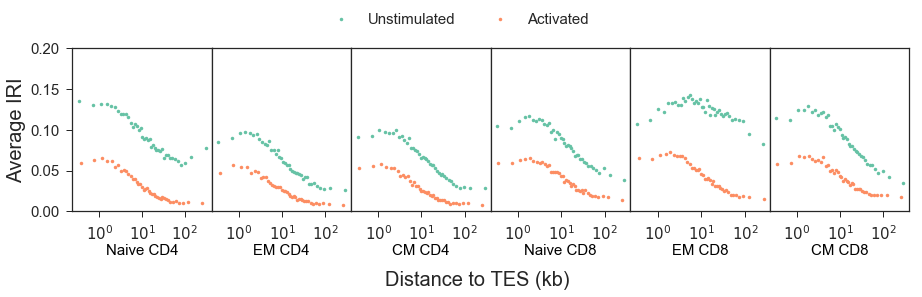

In [33]:
title_dict = {'Naive_CD4': 'Naive CD4',
              'EM_CD4': 'EM CD4',
              'CM_CD4': 'CM CD4',
              'Naive_CD8': 'Naive CD8',
              'EM_CD8': 'EM CD8',
              'CM_CD8': 'CM CD8',}

num_bins = 40
num_all = len(data_list)
num_innate = 0
plt.subplots(nrows=1,ncols=num_all, figsize=(15,3))
plt.subplots_adjust(wspace=0)
for i, sample in enumerate(data_list):
    if i < num_innate:
        sns.set_palette(sns.color_palette("Paired")[:2]) 
        color1, color2 = sns.color_palette("Paired")[:2]
    else:
#         sns.set_palette(sns.color_palette("Paired")[4:6]) 
#         color1, color2 = sns.color_palette("Paired")[4:6]
        sns.set_palette(sns.color_palette("Set2", 2))
        color1, color2 = sns.color_palette("Set2", 2)
        
    ax = plt.subplot(1,num_all, i+1)
    ax.locator_params(nbins=5, axis='y')
    
    rest_group_plot_df, active_group_plot_df = group_plot_df_dict[sample+'_Rest'], group_plot_df_dict[sample+'_Active']
    
    plt.plot(rest_group_plot_df['distance_to_TES'], rest_group_plot_df['intron_IRI'], '.')
    plt.plot(active_group_plot_df['distance_to_TES'], active_group_plot_df['intron_IRI'], '.')
    plt.xscale('log')
    plt.ylim(0, 0.2)
    plt.minorticks_off()
    plt.xticks(fontsize=15)
    if i == 0:
        plt.ylabel('Average IRI', fontsize=20)
        plt.yticks(size=15)
    else:
        plt.yticks([])
        
    if i == 0 or i == num_innate:
        #plt.legend(['resting','activated'], ncol=2, fontsize=15)
        #plt.legend(['resting','activated'], ncol=2, fontsize=15, bbox_to_anchor=(2.6, 1.5))
        #plt.legend(['Resting','Activated'], ncol=2, fontsize=15, bbox_to_anchor=(3.8, 1.3))
        plt.legend(['Unstimulated','Activated'], ncol=2, fontsize=15, bbox_to_anchor=(3.8, 1.3))
        leg = ax.get_legend()
        leg.legendHandles[0].set_color(color1)
        leg.legendHandles[1].set_color(color2)
#         leg.texts[0].set_color(color1)
#         leg.texts[1].set_color(color2)
    else:
        plt.legend([])
        
    if i < num_innate:
        plt.title(title_dict[sample], y=-0.3, fontsize=15, color='k')
    else:
        plt.title(title_dict[sample], y=-0.3, fontsize=15, color='k')
        
plt.suptitle('Distance to TES (kb)', y=-0.15, fontsize=20)

#### remove last intron

In [34]:
gene_num_CIR_dict = {}
simple_gene_list = []
gtffile = HTSeq.GFF_Reader('/Users/zzeng/Desktop/quick_visit/gtf_files/hg19_IR_annotation.gtf')
for feature in gtffile:
    if feature.type == 'gene_region':
        gene_id = feature.attr['gene_id']
        gene_num_CIR_dict[gene_id] = int(feature.attr['constitutive_intronic_region_number'])
        if int(feature.attr['transcripts_in_gene']) == 1:
            simple_gene_list.append(feature.attr['gene_id'])

In [35]:
df_dict = {}

for sample in data_list:
    name = sample+'_Rest'
    Rest_rep_df_list = []
    for i, data_full_path in enumerate(data_dict[name]):
        Rest_rep_df = pd.read_csv(data_full_path, header=0, sep='\t', na_values=['NA', "NA (5'AS)", "NA (3'AS)", "NA (unannotated exon)"]).loc[:,['CIR_id', 'intron_IRI', 'adjacent_CER_RPKM']]
        Rest_rep_df = Rest_rep_df[(Rest_rep_df.intron_IRI >= 0) & (Rest_rep_df.intron_IRI <= 1) & (Rest_rep_df.adjacent_CER_RPKM >= 0.1)].drop(labels=['adjacent_CER_RPKM'], axis=1).rename(columns={'intron_IRI': '{}_Rep{}_IRI'.format(name, i+1)})
        Rest_rep_df.set_index('CIR_id', inplace=True)
        Rest_rep_df_list.append(Rest_rep_df)
    Rest_df = pd.concat(Rest_rep_df_list, axis=1).dropna()
    Rest_df[name+'_IRI'] = Rest_df.apply(lambda row: np.mean(row[:]), axis=1)
    Rest_df = Rest_df.loc[:,[name+'_IRI']]
    
    Rest_df['gene_id'] = Rest_df.index.str[:-4]
    Rest_df['num_CIR'] = Rest_df.index.str[-3:].astype(int)
    Rest_df['is_last_intron'] = Rest_df.apply(lambda row: gene_num_CIR_dict[row['gene_id']] == row['num_CIR'], axis=1)
    
    name = sample+'_Active'
    Active_rep_df_list = []
    for i, data_full_path in enumerate(data_dict[name]):
        Active_rep_df = pd.read_csv(data_full_path, header=0, sep='\t', na_values=['NA', "NA (5'AS)", "NA (3'AS)", "NA (unannotated exon)"]).loc[:,['CIR_id', 'intron_IRI', 'adjacent_CER_RPKM']]
        Active_rep_df = Active_rep_df[(Active_rep_df.intron_IRI >= 0) & (Active_rep_df.intron_IRI <= 1) & (Active_rep_df.adjacent_CER_RPKM >= 1)].drop(labels=['adjacent_CER_RPKM'], axis=1).rename(columns={'intron_IRI': '{}_Rep{}_IRI'.format(name, i+1)})
        Active_rep_df.set_index('CIR_id', inplace=True)
        Active_rep_df_list.append(Active_rep_df)
    Active_df = pd.concat(Active_rep_df_list, axis=1).dropna()
    Active_df[name+'_IRI'] = Active_df.apply(lambda row: np.mean(row[:]), axis=1)
    Active_df = Active_df.loc[:,[name+'_IRI']]
    
    Active_df['gene_id'] = Active_df.index.str[:-4]
    Active_df['num_CIR'] = Active_df.index.str[-3:].astype(int)
    Active_df['is_last_intron'] = Active_df.apply(lambda row: gene_num_CIR_dict[row['gene_id']] == row['num_CIR'], axis=1)
    
    df_dict[sample+'_Rest'] = Rest_df
    df_dict[sample+'_Active'] = Active_df

In [37]:
num_bins = 40
group_plot_df_dict = {}
for i, sample in enumerate(data_list):
    rest_intron_IRI_df = df_dict[sample+'_Rest'].reset_index().rename(columns={'index': 'CIR_id', sample+'_Rest_IRI': 'intron_IRI'})
    rest_plot_df = rest_intron_IRI_df[~rest_intron_IRI_df['is_last_intron']].merge(distance_df, on='CIR_id').dropna()

    rest_plot_df.sort_values(by='distance_to_TES', inplace=True)
    rest_plot_df['distance_to_TES_bin'] = reduce(lambda x, (i, y): x + [i] * len(y), enumerate(np.array_split(range(rest_plot_df.shape[0]), num_bins)), [])

    rest_group_plot_df = rest_plot_df.groupby('distance_to_TES_bin')[['distance_to_TES', 'intron_IRI']].mean()
    
    active_intron_IRI_df = df_dict[sample+'_Active'].reset_index().rename(columns={'index': 'CIR_id', sample+'_Active_IRI': 'intron_IRI'})
    active_plot_df = active_intron_IRI_df[~active_intron_IRI_df['is_last_intron']].merge(distance_df, on='CIR_id').dropna()

    active_plot_df.sort_values(by='distance_to_TES', inplace=True)
    active_plot_df['distance_to_TES_bin'] = reduce(lambda x, (i, y): x + [i] * len(y), enumerate(np.array_split(range(active_plot_df.shape[0]), num_bins)), [])

    active_group_plot_df = active_plot_df.groupby('distance_to_TES_bin')[['distance_to_TES', 'intron_IRI']].mean()
    
    group_plot_df_dict[sample+'_Rest'] = rest_group_plot_df
    group_plot_df_dict[sample+'_Active'] = active_group_plot_df

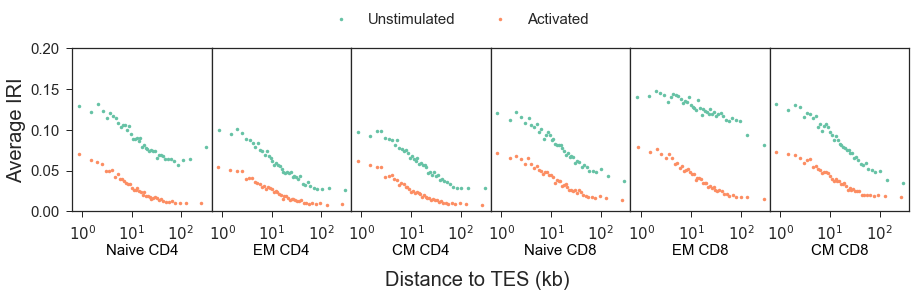

In [38]:
title_dict = {'Naive_CD4': 'Naive CD4',
              'EM_CD4': 'EM CD4',
              'CM_CD4': 'CM CD4',
              'Naive_CD8': 'Naive CD8',
              'EM_CD8': 'EM CD8',
              'CM_CD8': 'CM CD8',}

num_bins = 40
num_all = len(data_list)
num_innate = 0
plt.subplots(nrows=1,ncols=num_all, figsize=(15,3))
plt.subplots_adjust(wspace=0)
for i, sample in enumerate(data_list):
    if i < num_innate:
        sns.set_palette(sns.color_palette("Paired")[:2]) 
        color1, color2 = sns.color_palette("Paired")[:2]
    else:
#         sns.set_palette(sns.color_palette("Paired")[4:6]) 
#         color1, color2 = sns.color_palette("Paired")[4:6]
        sns.set_palette(sns.color_palette("Set2", 2))
        color1, color2 = sns.color_palette("Set2", 2)
        
    ax = plt.subplot(1,num_all, i+1)
    ax.locator_params(nbins=5, axis='y')
    
    rest_group_plot_df, active_group_plot_df = group_plot_df_dict[sample+'_Rest'], group_plot_df_dict[sample+'_Active']
    
    plt.plot(rest_group_plot_df['distance_to_TES'], rest_group_plot_df['intron_IRI'], '.')
    plt.plot(active_group_plot_df['distance_to_TES'], active_group_plot_df['intron_IRI'], '.')
    plt.xscale('log')
    plt.ylim(0, 0.2)
    plt.minorticks_off()
    plt.xticks(fontsize=15)
    if i == 0:
        plt.ylabel('Average IRI', fontsize=20)
        plt.yticks(size=15)
    else:
        plt.yticks([])
        
    if i == 0 or i == num_innate:
        #plt.legend(['resting','activated'], ncol=2, fontsize=15)
        #plt.legend(['resting','activated'], ncol=2, fontsize=15, bbox_to_anchor=(2.6, 1.5))
        #plt.legend(['Resting','Activated'], ncol=2, fontsize=15, bbox_to_anchor=(3.8, 1.3))
        plt.legend(['Unstimulated','Activated'], ncol=2, fontsize=15, bbox_to_anchor=(3.8, 1.3))
        leg = ax.get_legend()
        leg.legendHandles[0].set_color(color1)
        leg.legendHandles[1].set_color(color2)
#         leg.texts[0].set_color(color1)
#         leg.texts[1].set_color(color2)
    else:
        plt.legend([])
        
    if i < num_innate:
        plt.title(title_dict[sample], y=-0.3, fontsize=15, color='k')
    else:
        plt.title(title_dict[sample], y=-0.3, fontsize=15, color='k')
        
plt.suptitle('Distance to TES (kb)', y=-0.15, fontsize=20)

### GBTree

In [73]:
auc_dict = {}

data_path = '/Users/zzeng/Documents/GitHub/ML_code/exp_IRI_intron_level_splicing/length'
for fname in filter(lambda f: re.search('exp_gbtree\S+log', f), os.listdir(data_path)):
    feature = re.search('exp_gbtree_add_(\S+).log', fname).group(1)
    auc_dict[feature] = get_auc_list(os.path.join(data_path, fname))[1]
    
del auc_dict['pos']
del auc_dict['relative_pos']

In [75]:
#legend_dict = {'distance_to_TES': 'distance to TES', 'gene_length': 'gene length', 'distance_to_TSS': 'distance to TSS', 'intron_length': 'intron length'}
legend_dict = {'distance_to_TES': 'distance to TES', 'gene_length': 'gene length', 'distance_to_TSS': 'distance to TSS', 'intron_length': 'intron length', 'pos': 'position', 'relative_pos': 'normalized position', 'relative_distance_to_TSS': 'normalized distance to TSS', 'relative_distance_to_TES': 'normalized distance to TES'}

In [76]:
boxplot_tuple = []
for feature in auc_dict.keys():
    for auc in auc_dict[feature]:
        boxplot_tuple.append((legend_dict[feature], auc))

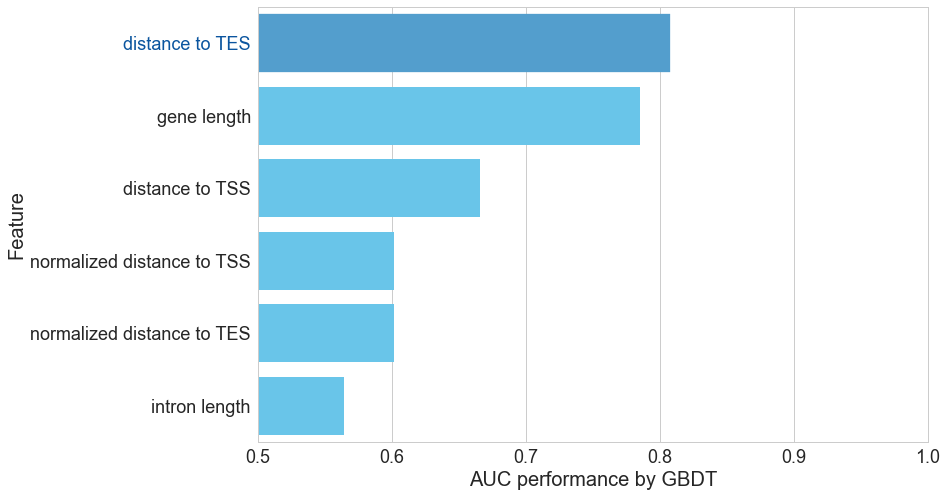

In [77]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,8))
ax = sns.barplot(boxplot_mean_df, boxplot_mean_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by GBDT', fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel('Feature', fontsize=20)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

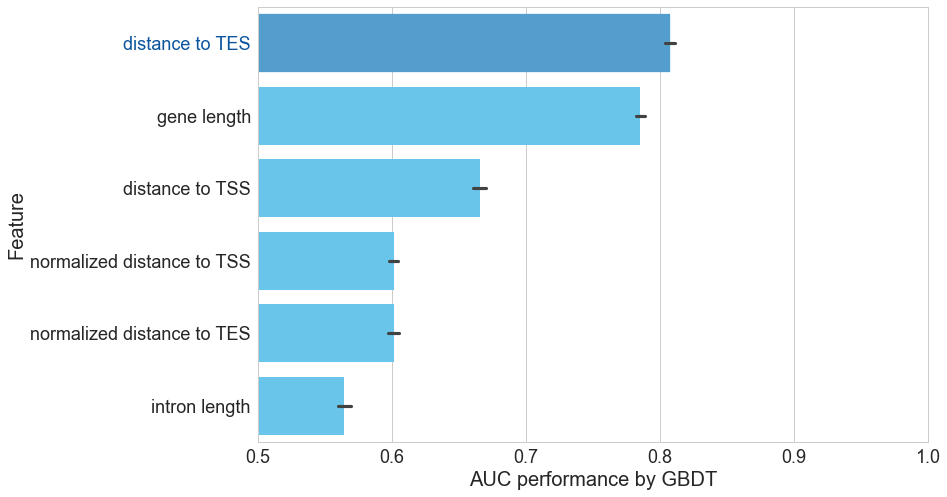

In [78]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

boxplot_errorbar_df = boxplot_df.set_index('feature')[['test auc']]
boxplot_errorbar_df['mean'] = boxplot_df.groupby('feature')['test auc'].mean()
boxplot_errorbar_df.sort_values(by='mean', ascending=False, inplace=True)
boxplot_errorbar_df = boxplot_errorbar_df['test auc']

plt.figure(figsize=(12,8))
ax = sns.barplot(boxplot_errorbar_df, boxplot_errorbar_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by GBDT', fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel('Feature', fontsize=20)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

### LR

In [79]:
auc_dict = {}

data_path = '/Users/zzeng/Documents/GitHub/ML_code/exp_IRI_intron_level_splicing/length'
for fname in filter(lambda f: re.search('exp_LR\S+log', f), os.listdir(data_path)):
    feature = re.search('exp_LR_st_add_(\S+).log', fname).group(1)
    auc_dict[feature] = get_auc_list(os.path.join(data_path, fname))[1]
    
del auc_dict['pos']
del auc_dict['relative_pos']

In [80]:
boxplot_tuple = []
for feature in auc_dict.keys():
    for auc in auc_dict[feature]:
        boxplot_tuple.append((legend_dict[feature], auc))

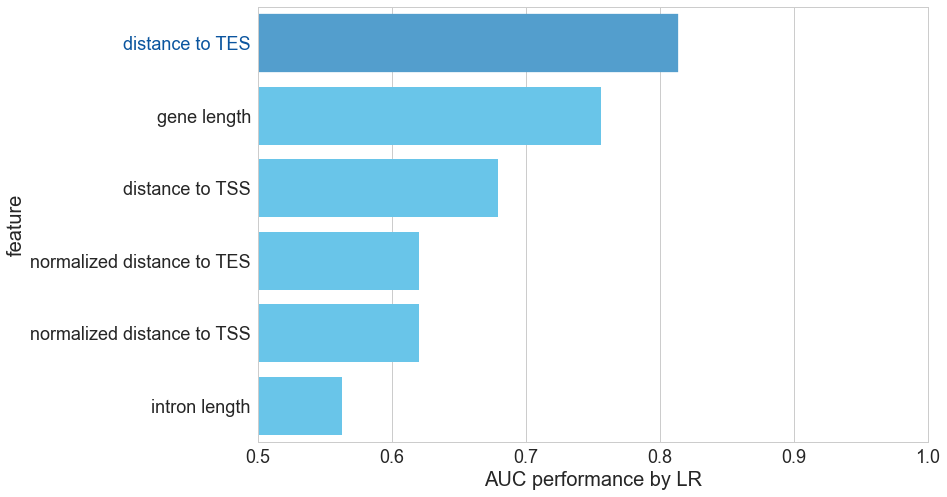

In [83]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,8))
ax = sns.barplot(boxplot_mean_df, boxplot_mean_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by LR', fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel('feature', fontsize=20)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

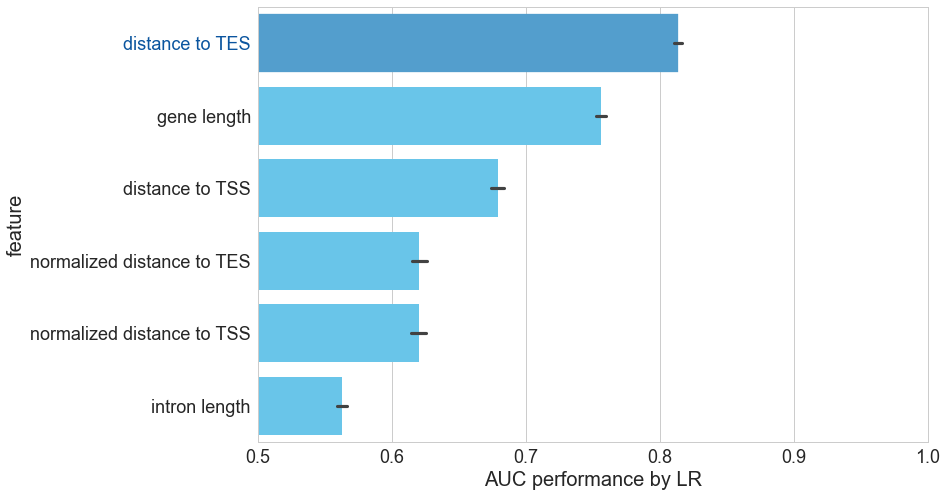

In [82]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

boxplot_errorbar_df = boxplot_df.set_index('feature')[['test auc']]
boxplot_errorbar_df['mean'] = boxplot_df.groupby('feature')['test auc'].mean()
boxplot_errorbar_df.sort_values(by='mean', ascending=False, inplace=True)
boxplot_errorbar_df = boxplot_errorbar_df['test auc']

plt.figure(figsize=(12,8))
ax = sns.barplot(boxplot_errorbar_df, boxplot_errorbar_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by LR', fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel('feature', fontsize=20)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

### GBTree simple genes

In [6]:
auc_dict = {}

data_path = '/Users/zzeng/Documents/GitHub/ML_code/exp_IRI_intron_level_splicing/length/simple_genes/'
for fname in filter(lambda f: re.search('exp_gbtree\S+log', f), os.listdir(data_path)):
    feature = re.search('exp_gbtree_add_(\S+).log', fname).group(1)
    auc_dict[feature] = get_auc_list(os.path.join(data_path, fname))[1]

In [9]:
boxplot_tuple = []
for feature in auc_dict.keys():
    for auc in auc_dict[feature]:
        boxplot_tuple.append((legend_dict[feature], auc))

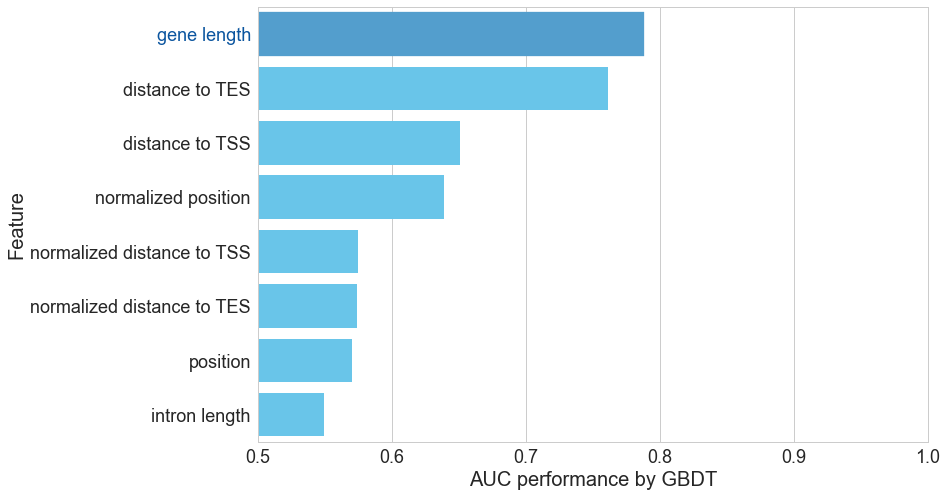

In [10]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,8))
ax = sns.barplot(boxplot_mean_df, boxplot_mean_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by GBDT', fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel('Feature', fontsize=20)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

### LR simple genes

In [11]:
auc_dict = {}

data_path = '/Users/zzeng/Documents/GitHub/ML_code/exp_IRI_intron_level_splicing/length/simple_genes/'
for fname in filter(lambda f: re.search('exp_LR\S+log', f), os.listdir(data_path)):
    feature = re.search('exp_LR_st_add_(\S+).log', fname).group(1)
    auc_dict[feature] = get_auc_list(os.path.join(data_path, fname))[1]

In [12]:
boxplot_tuple = []
for feature in auc_dict.keys():
    for auc in auc_dict[feature]:
        boxplot_tuple.append((legend_dict[feature], auc))

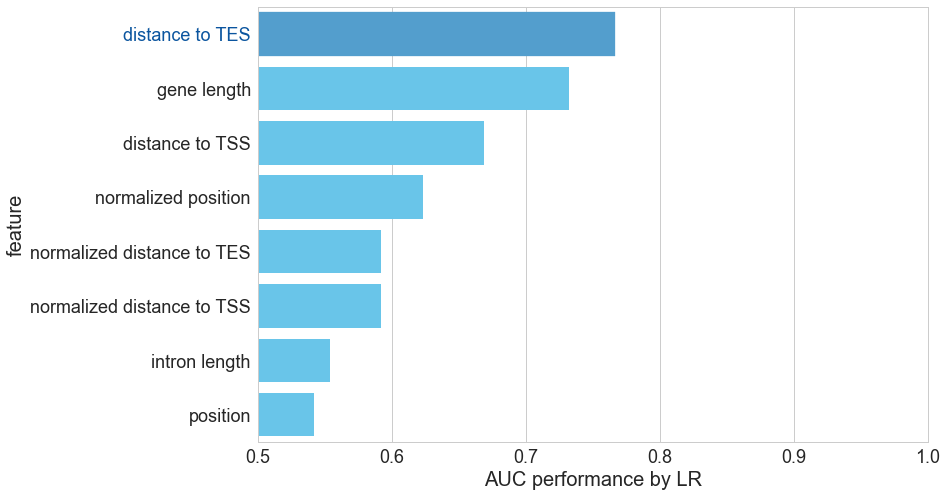

In [13]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,8))
ax = sns.barplot(boxplot_mean_df, boxplot_mean_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by LR', fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel('feature', fontsize=20)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

## RBP

### eclip better than motif

In [26]:
sys.path.append('/Users/zzeng/Documents/GitHub/ML_code')
from IR_predict_intron_level_splicing import *
os.chdir('/Users/zzeng/Documents/GitHub/ML_code')

from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

/Library/Python/2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [27]:
ROC_dict = {}
PRC_dict = {}
ROC_auc_dict = {}
PRC_auc_dict = {}

features_list = ['RBP_motif', 'splice_site_score']
model_type_list = ['xgboost:gbtree', 'LR']

for features in features_list:
    for model_type in model_type_list:  
        np.random.seed(0)
        if features:
            feature_list = features.split(',')
            feature_dict = dict([(feature, True) for feature in feature_list])
            train_test_df = load_data(**feature_dict)
        else:
            train_test_df = load_data()
            
        if model_type == 'LR':
            X_train, X_test, y_train, y_test, feature_list, train_indice, test_indice = process_train_test_df(train_test_df, standarization=True)
        else: 
            X_train, X_test, y_train, y_test, feature_list, train_indice, test_indice = process_train_test_df(train_test_df)
            
        model = train(X_train, y_train, X_test, y_test, model_type=model_type)
        y_test_pred_prob = predict(model, model_type, X_test, y_test, output_auc=True)
        
        fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
        precision, recall, _ = precision_recall_curve(y_test, y_test_pred_prob)
        
        ROC_dict[features + ',' + model_type] = (fpr, tpr)
        PRC_dict[features + ',' + model_type] = (precision, recall)
        
        ROC_auc_dict[features + ',' + model_type] = roc_auc_score(y_test, y_test_pred_prob)
        PRC_auc_dict[features + ',' + model_type] = average_precision_score(y_test, y_test_pred_prob)

Multiple eval metrics have been passed: 'auc' will be used for early stopping.



train auc: 0.951772328988

test auc: 0.767056614038

train auc: 0.813081641934

test auc: 0.766077578793



Multiple eval metrics have been passed: 'auc' will be used for early stopping.



train auc: 0.821303001241

test auc: 0.602179597392

train auc: 0.573894604303

test auc: 0.580469589512



### GBDT

In [28]:
features_list = ['RBP_motif', 'splice_site_score']
model_type_list = ['xgboost:gbtree']

legend_dict = dict(zip([x+','+y for (x,y) in itertools.product(features_list, model_type_list)],
                       ['motif by GBDT', 'splice site score by GBDT']))

In [29]:
ROC_dict.keys()

['RBP_motif,xgboost:gbtree',
 'RBP_motif,LR',
 'splice_site_score,xgboost:gbtree',
 'splice_site_score,LR']

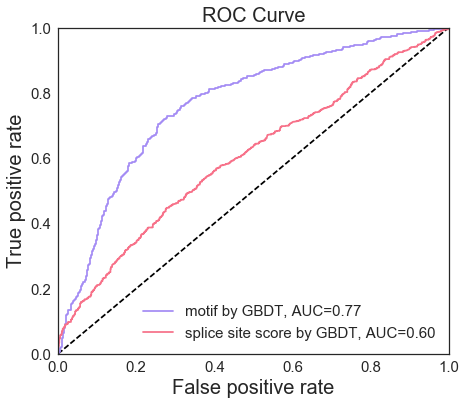

In [30]:
sns.set_style("white")
plt.figure(figsize=(7,6))
color_list = sns.color_palette('husl', 8)[6:7] + sns.color_palette('husl', 8)[0:2]
plt.plot([0, 1], [0, 1], 'k--')
for i, key in enumerate(['RBP_motif,xgboost:gbtree', 'splice_site_score,xgboost:gbtree']):
    fpr, tpr = ROC_dict[key]
    plt.plot(fpr, tpr, label='%s, AUC=%.2f' % (legend_dict[key], ROC_auc_dict[key]), color=color_list[i])
plt.xlim(0,1)
plt.ylim(0,1)

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC Curve', fontsize=20)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### LR

In [31]:
features_list = ['RBP_motif', 'splice_site_score']
model_type_list = ['LR']

legend_dict = dict(zip([x+','+y for (x,y) in itertools.product(features_list, model_type_list)],
                       ['motif by LR', 'splice site score by LR']))

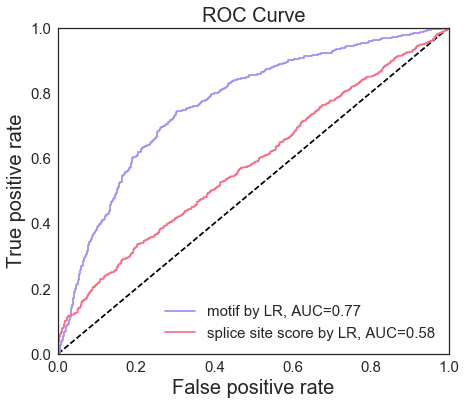

In [32]:
sns.set_style("white")
plt.figure(figsize=(7,6))
color_list = sns.color_palette('husl', 8)[6:7] + sns.color_palette('husl', 8)[0:2]
plt.plot([0, 1], [0, 1], 'k--')
for i, key in enumerate(['RBP_motif,LR', 'splice_site_score,LR']):
    fpr, tpr = ROC_dict[key]
    plt.plot(fpr, tpr, label='%s, AUC=%.2f' % (legend_dict[key], ROC_auc_dict[key]), color=color_list[i])
plt.xlim(0,1)
plt.ylim(0,1)

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC Curve', fontsize=20)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [51]:
features_list = ['RBP_binding_score_eclip', 'RBP_motif']
model_type_list = ['xgboost:gbtree', 'LR']

legend_dict = dict(zip([x+','+y for (x,y) in itertools.product(features_list, model_type_list)],
                       ['eCLIP by GBDT', 'eCLIP by LR', 'motif by GBDT', 'motif by LR']))

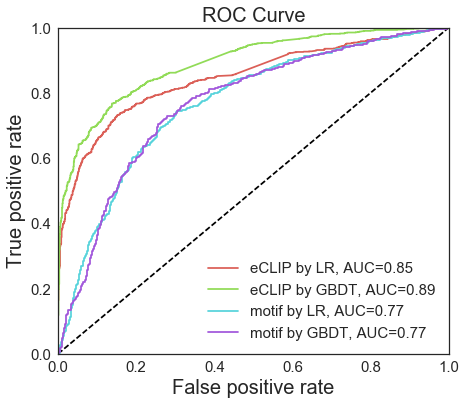

In [52]:
sns.set_style("white")
plt.figure(figsize=(7,6))
color_list = sns.color_palette('hls', 4) 
plt.plot([0, 1], [0, 1], 'k--')
for i, key in enumerate(ROC_dict.keys()):
    fpr, tpr = ROC_dict[key]
    plt.plot(fpr, tpr, label='%s, AUC=%.2f' % (legend_dict[key], ROC_auc_dict[key]), color=color_list[i])
plt.xlim(0,1)
plt.ylim(0,1)

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC Curve', fontsize=20)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

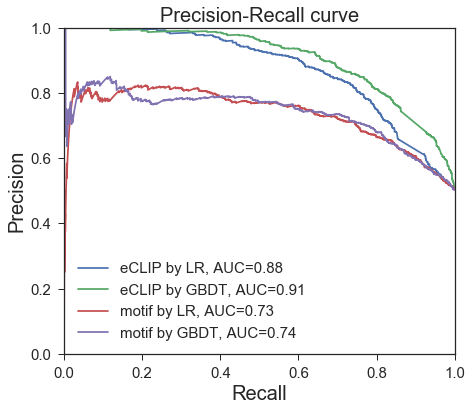

In [167]:
plt.figure(figsize=(7,6))
for key in PRC_dict.keys():
    precision, recall = PRC_dict[key]
    plt.plot(recall, precision, label='%s, AUC=%.2f' % (legend_dict[key], PRC_auc_dict[key]))
plt.xlim(0,1)
plt.ylim(0,1)

plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.title('Precision-Recall curve', fontsize=20)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### RBP list

In [46]:
eclip_df = pd.read_csv('/Users/zzeng/Documents/GitHub/ML_code/data/IRstat.RBP_binding_score_eclip_K562.introns.txt', header=0, sep='\t')

In [7]:
' '.join(eclip_df.columns[1:].str.extract(r'\S+_(\S+)$').unique())

/Library/Python/2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


'AARS AGGF1 AKAP8L AUH BUD13 CPSF6 CSTF2T DDX24 DDX3X DDX42 DDX55 DDX6 DGCR8 DHX30 DROSHA EFTUD2 EIF4G2 EWSR1 FAM120A FASTKD2 FMR1 FTO FXR1 FXR2 GEMIN5 GNL3 GPKOW GTF2F1 HLTF HNRNPA1 HNRNPK HNRNPM HNRNPU HNRNPUL1 IGF2BP1 IGF2BP2 ILF3 KHDRBS1 KHSRP LARP4 LARP7 LIN28B LSM11 METAP2 MTPAP NCBP2 NONO NPM1 NSUN2 PPIL4 PRPF8 PTBP1 PUM2 PUS1 QKI RBFOX2 RBM15 RBM22 RPS11 RPS5 SAFB2 SBDS SERBP1 SF3B1 SF3B4 SLBP SLTM SMNDC1 SND1 SRSF1 SRSF7 TAF15 TARDBP TBRG4 TIA1 TRA2A TROVE2 U2AF1 U2AF2 UCHL5 UPF1 XRCC6 XRN2 YBX3 YWHAG ZNF622 ZRANB2'

In [21]:
motif_df = pd.read_csv('/Users/zzeng/Documents/GitHub/ML_code/core_circuit/data/exploration/motif/fimo/IRstat.RBP_motif.upstream_CIR.introns.txt', header=0, sep='\t')

In [97]:
' ' .join(motif_df.columns[1:].unique())

'A1CF A2BP1 ANKHD1 ARET ASD-1 AT1G76460-TAIR-G An_0265 B52 BRU-3 BRUNOL4 BRUNOL5 BRUNOL6 CADANIAG00004740 CG11360 CG14718 CG17838 CG2931 CG2950 CG33714 CG5213 CG7804 CG7903 CNOT4 CPEB2 CPEB4 CPO DAZAP1 EIF-2ALPHA ELAV ENOX1 ENSDARG00000058818 ENSGALG00000000814 ENSGALG00000003765 ENSGALG00000014267 ENSTNIG00000009181 ENSXETG00000007102 ENSXETG00000012802 ENSXETG00000017599 ENSXETG00000018075 ESRP2 ETR-1 EXC-7 FMR1 FNE FOX-1 FUS FXR1 FXR2 G3BP2 HNRNPA1 HNRNPA1L2 HNRNPA2B1 HNRNPAB HNRNPC HNRNPCL1 HNRNPH2 HNRNPK HNRNPL HNRPLL HOW HRB27C HRB87F HRB98DE Hrp1p HuR IGF2BP2 IGF2BP3 KHDRBS1 KHDRBS2 KHDRBS3 LARK LIN28A Lm_0212 Lm_0223 Lm_0254 Lm_0255 MAL13P1.35 MAL8P1.40 MATR3 MBNL1 MEC-8 MEX-5 MOD MSI MSI1 MUB NCU02404 NCU08034 Nab2p Ng_0261 ORB2 Ot_0262 Ot_0263 PABP PABPC1 PABPC3 PABPC4 PABPC5 PABPN1 PAPI PCBP1 PCBP2 PCBP3 PF10_0068 PF10_0214 PF13_0315 PFF0320c PFI1435w PFI1695c PPRC1 PTBP1 PUF68 PUM Pcbp2 Pp_0206 Pp_0228 Pp_0229 Pp_0237 Pr_0249 QKI QKR58E-1 RALY RBFOX1 RBM24 RBM28 RBM3 RBM38 

### eclip

#### gbtree

In [47]:
auc_dict = {}

data_path = '/Users/zzeng/Documents/GitHub/ML_code/exp_IRI_intron_level_splicing/RBP'
for fname in filter(lambda f: re.search('exp_gbtree_add_eclip_\S+log', f), os.listdir(data_path)):
    feature = re.search('exp_gbtree_add_eclip_RBP_(\S+).log', fname).group(1)
    auc_dict[feature] = get_auc_list(os.path.join(data_path, fname))[1]

data_path = '/Users/zzeng/Documents/GitHub/ML_code/exp_IRI_intron_level_splicing'
fname = 'exp_gbtree_add_eclip.log'
auc_dict.update({'combined': get_auc_list(os.path.join(data_path, fname))[1]})

In [9]:
boxplot_tuple = []
for feature in auc_dict.keys():
    for auc in auc_dict[feature]:
        boxplot_tuple.append((feature, auc))

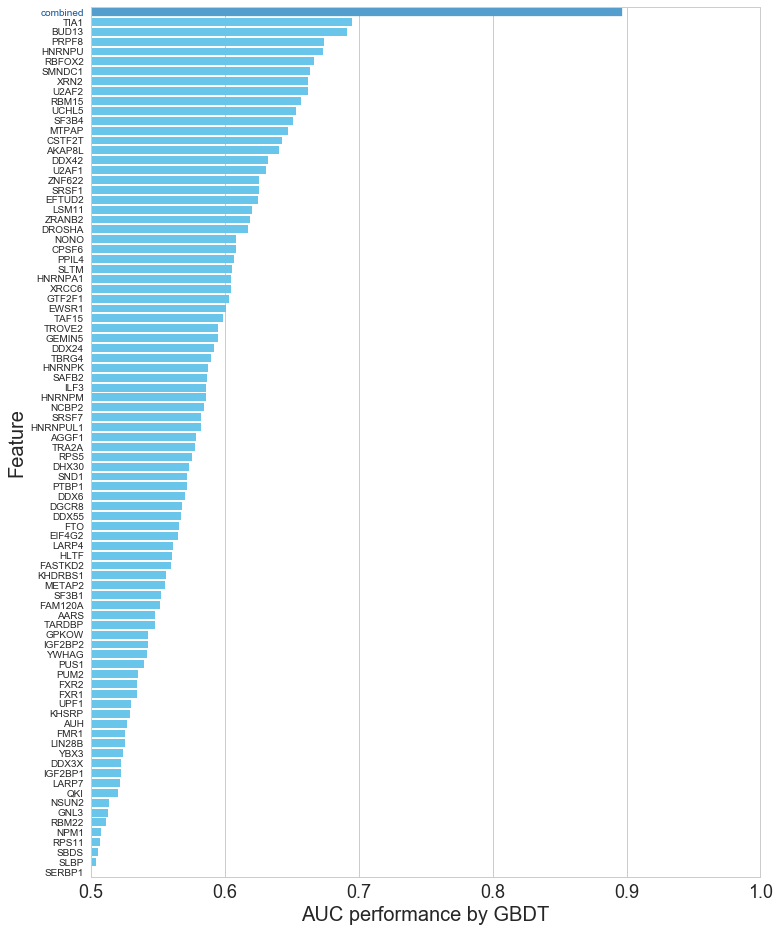

In [8]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,16))
ax = sns.barplot(boxplot_mean_df, boxplot_mean_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by GBDT', fontsize=20)
plt.yticks(fontsize=10)
plt.ylabel('Feature', fontsize=20)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

In [11]:
boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)



In [13]:
all_IR_down_gene_str = 'EIF2S1,\
                        EIF4A3,\
                        EIF4B,\
                        FUBP3,\
 FXR1,\
 G3BP1,\
 G3BP2,\
 HNRNPK,\
 IGF2BP2,\
 IGF2BP3,\
 KHSRP,\
 MAGOH,\
 MATR3,\
 NCBP2,\
 NELFE,\
 PABPC4,\
 PCBP1,\
 PRPF8,\
 PTBP1,\
 QKI,\
 RBM25,\
 RECQL,\
 SF3B4,\
 SRSF1,\
 SRSF7,\
 SRSF9,\
 TAF15,\
 TIA1,\
 PCBP2,\
 RBM22'

In [14]:
all_IR_down_gene_list = [x for x in re.sub(' ', '', all_IR_down_gene_str).split(',')] 

In [17]:
boxplot_mean_df[all_IR_down_gene_list]

feature
EIF2S1          NaN
EIF4A3          NaN
EIF4B           NaN
FUBP3           NaN
FXR1       0.534757
G3BP1           NaN
G3BP2           NaN
HNRNPK     0.587345
IGF2BP2    0.542463
IGF2BP3         NaN
KHSRP      0.529539
MAGOH           NaN
MATR3           NaN
NCBP2      0.584595
NELFE           NaN
PABPC4          NaN
PCBP1           NaN
PRPF8      0.674029
PTBP1      0.571783
QKI        0.520532
RBM25           NaN
RECQL           NaN
SF3B4      0.651155
SRSF1      0.625220
SRSF7      0.582424
SRSF9           NaN
TAF15      0.598496
TIA1       0.694943
PCBP2           NaN
RBM22      0.511057
Name: test auc, dtype: float64

##### shortened RBP list

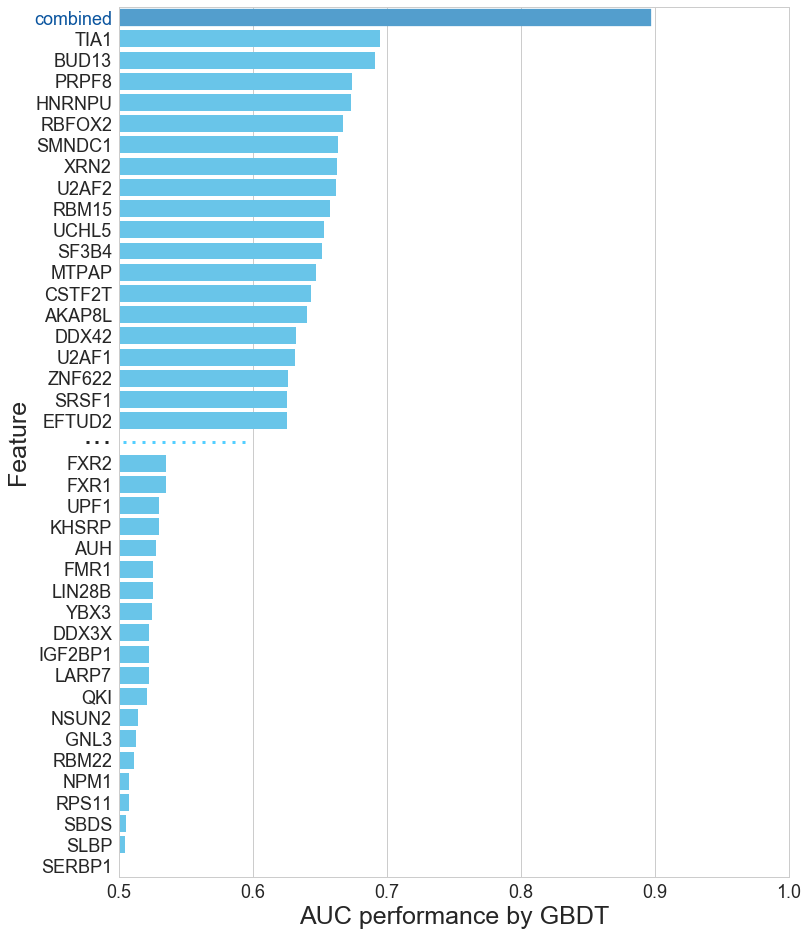

In [102]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

boxplot_errorbar_df = boxplot_df.set_index('feature')['test auc'].sort_values(ascending=False)

num_RBP = boxplot_mean_df.shape[0]
barplot_df = boxplot_mean_df.iloc[range(20)].append(pd.Series({u'···': 0})).append(boxplot_mean_df.iloc[range(num_RBP-20,num_RBP)])

plt.figure(figsize=(12,16))
ax = sns.barplot(barplot_df, barplot_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by GBDT', fontsize=25)
plt.yticks(fontsize=18)
plt.ylabel('Feature', fontsize=25)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

ax.get_yticklabels()[20].set_fontsize(30)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

plt.text(0.5, 20.5, u'·············', fontsize=30, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))

#### add error bar

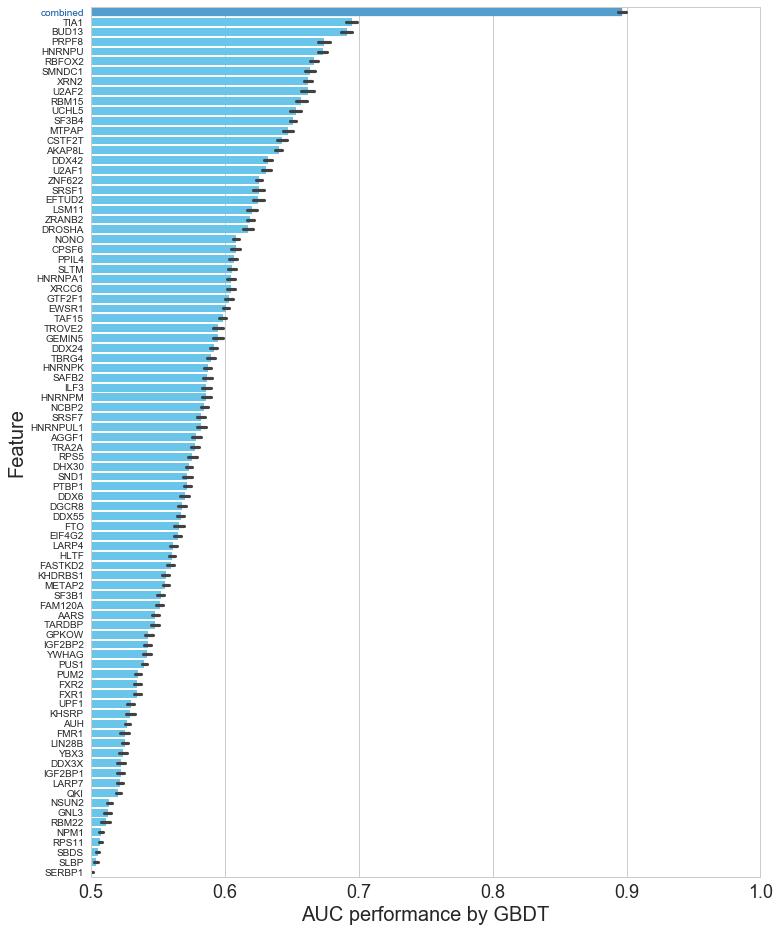

In [42]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

boxplot_errorbar_df = boxplot_df.set_index('feature')[['test auc']]
boxplot_errorbar_df['mean'] = boxplot_df.groupby('feature')['test auc'].mean()
boxplot_errorbar_df.sort_values(by='mean', ascending=False, inplace=True)
boxplot_errorbar_df = boxplot_errorbar_df['test auc']

plt.figure(figsize=(12,16))
#ax = sns.barplot(boxplot_mean_df, boxplot_mean_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
ax = sns.barplot(boxplot_errorbar_df, boxplot_errorbar_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by GBDT', fontsize=20)
plt.yticks(fontsize=10)
plt.ylabel('Feature', fontsize=20)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

##### shortened list with error bar 

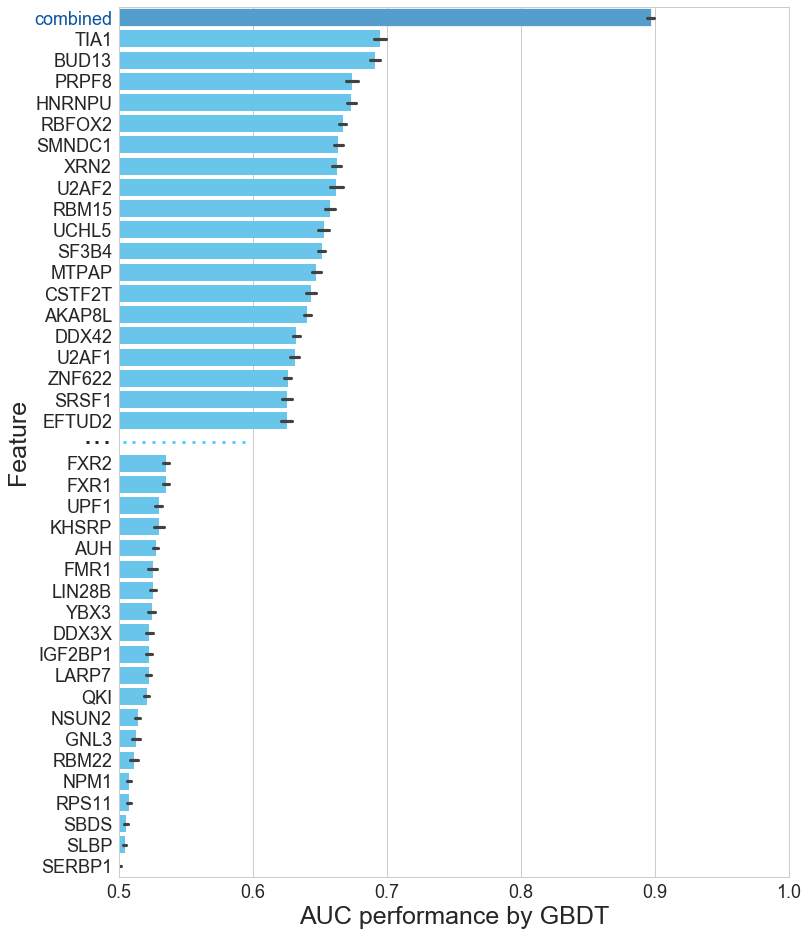

In [41]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_df['mean'] = boxplot_df.groupby('feature')['test auc'].mean()
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

boxplot_errorbar_df = boxplot_df.set_index('feature')[['test auc']]
boxplot_errorbar_df['mean'] = boxplot_df.groupby('feature')['test auc'].mean()
boxplot_errorbar_df.sort_values(by='mean', ascending=False, inplace=True)
boxplot_errorbar_df = boxplot_errorbar_df['test auc']

num_RBP = boxplot_mean_df.shape[0]
num_rep = 20
barplot_df = boxplot_errorbar_df.iloc[range(20 * num_rep)].append(pd.Series({u'···': 0})).append(boxplot_errorbar_df.iloc[range((num_RBP-20) * num_rep, num_RBP * num_rep)])

plt.figure(figsize=(12,16))
ax = sns.barplot(barplot_df, barplot_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by GBDT', fontsize=25)
plt.yticks(fontsize=18)
plt.ylabel('Feature', fontsize=25)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

ax.get_yticklabels()[20].set_fontsize(30)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

plt.text(0.5, 20.5, u'·············', fontsize=30, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))

#### LR

In [63]:
auc_dict = {}

data_path = '/Users/zzeng/Documents/GitHub/ML_code/exp_IRI_intron_level_splicing/RBP'
for fname in filter(lambda f: re.search('exp_LR_st_add_eclip_\S+log', f), os.listdir(data_path)):
    feature = re.search('exp_LR_st_add_eclip_RBP_(\S+).log', fname).group(1)
    auc_dict[feature] = get_auc_list(os.path.join(data_path, fname))[1]

data_path = '/Users/zzeng/Documents/GitHub/ML_code/exp_IRI_intron_level_splicing'
fname = 'exp_LR_st_add_eclip.log'
auc_dict.update({'combined': get_auc_list(os.path.join(data_path, fname))[1]})

In [64]:
boxplot_tuple = []
for feature in auc_dict.keys():
    for auc in auc_dict[feature]:
        boxplot_tuple.append((feature, auc))

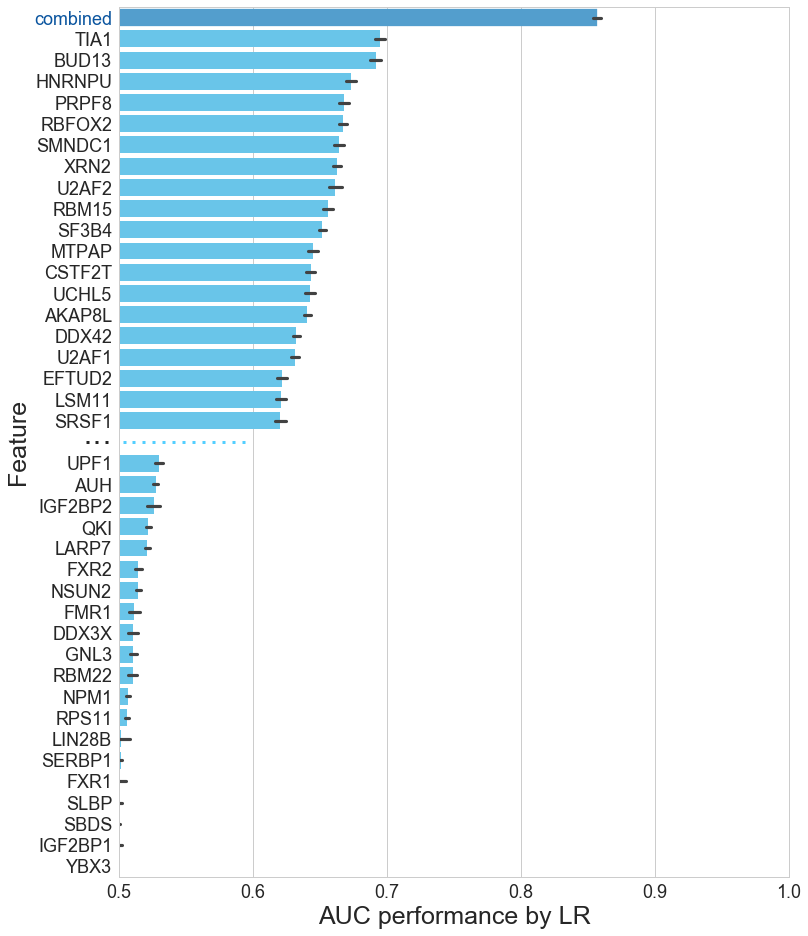

In [65]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_df['mean'] = boxplot_df.groupby('feature')['test auc'].mean()
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

boxplot_errorbar_df = boxplot_df.set_index('feature')[['test auc']]
boxplot_errorbar_df['mean'] = boxplot_df.groupby('feature')['test auc'].mean()
boxplot_errorbar_df.sort_values(by='mean', ascending=False, inplace=True)
boxplot_errorbar_df = boxplot_errorbar_df['test auc']

num_RBP = boxplot_mean_df.shape[0]
num_rep = 20
barplot_df = boxplot_errorbar_df.iloc[range(20 * num_rep)].append(pd.Series({u'···': 0})).append(boxplot_errorbar_df.iloc[range((num_RBP-20) * num_rep, num_RBP * num_rep)])

plt.figure(figsize=(12,16))
ax = sns.barplot(barplot_df, barplot_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by LR', fontsize=25)
plt.yticks(fontsize=18)
plt.ylabel('Feature', fontsize=25)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

ax.get_yticklabels()[20].set_fontsize(30)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

plt.text(0.5, 20.5, u'·············', fontsize=30, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))

### motif

#### gbtree

In [66]:
auc_dict = {}

data_path = '/Users/zzeng/Documents/GitHub/ML_code/exp_IRI_intron_level_splicing/RBP'
for fname in filter(lambda f: re.search('exp_gbtree_add_motif_\S+log', f), os.listdir(data_path)):
    feature = re.search('exp_gbtree_add_motif_RBP_(\S+).log', fname).group(1)
    auc_dict[feature] = get_auc_list(os.path.join(data_path, fname))[1]

data_path = '/Users/zzeng/Documents/GitHub/ML_code/exp_IRI_intron_level_splicing'
fname = 'exp_gbtree_add_motif.log'
auc_dict.update({'combined': get_auc_list(os.path.join(data_path, fname))[1]})

In [67]:
boxplot_tuple = []
for feature in auc_dict.keys():
    for auc in auc_dict[feature]:
        boxplot_tuple.append((feature, auc))

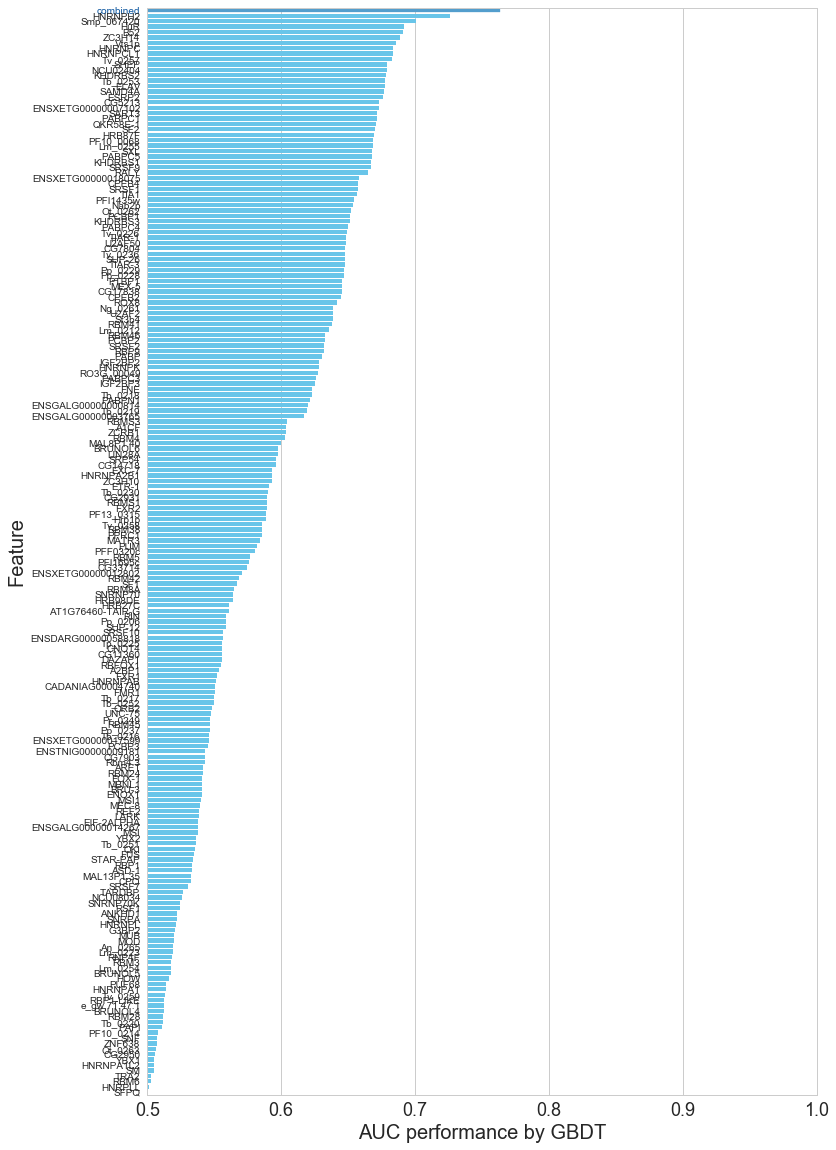

In [49]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,20))
ax = sns.barplot(boxplot_mean_df, boxplot_mean_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by GBDT', fontsize=20)
plt.yticks(fontsize=10)
plt.ylabel('Feature', fontsize=20)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

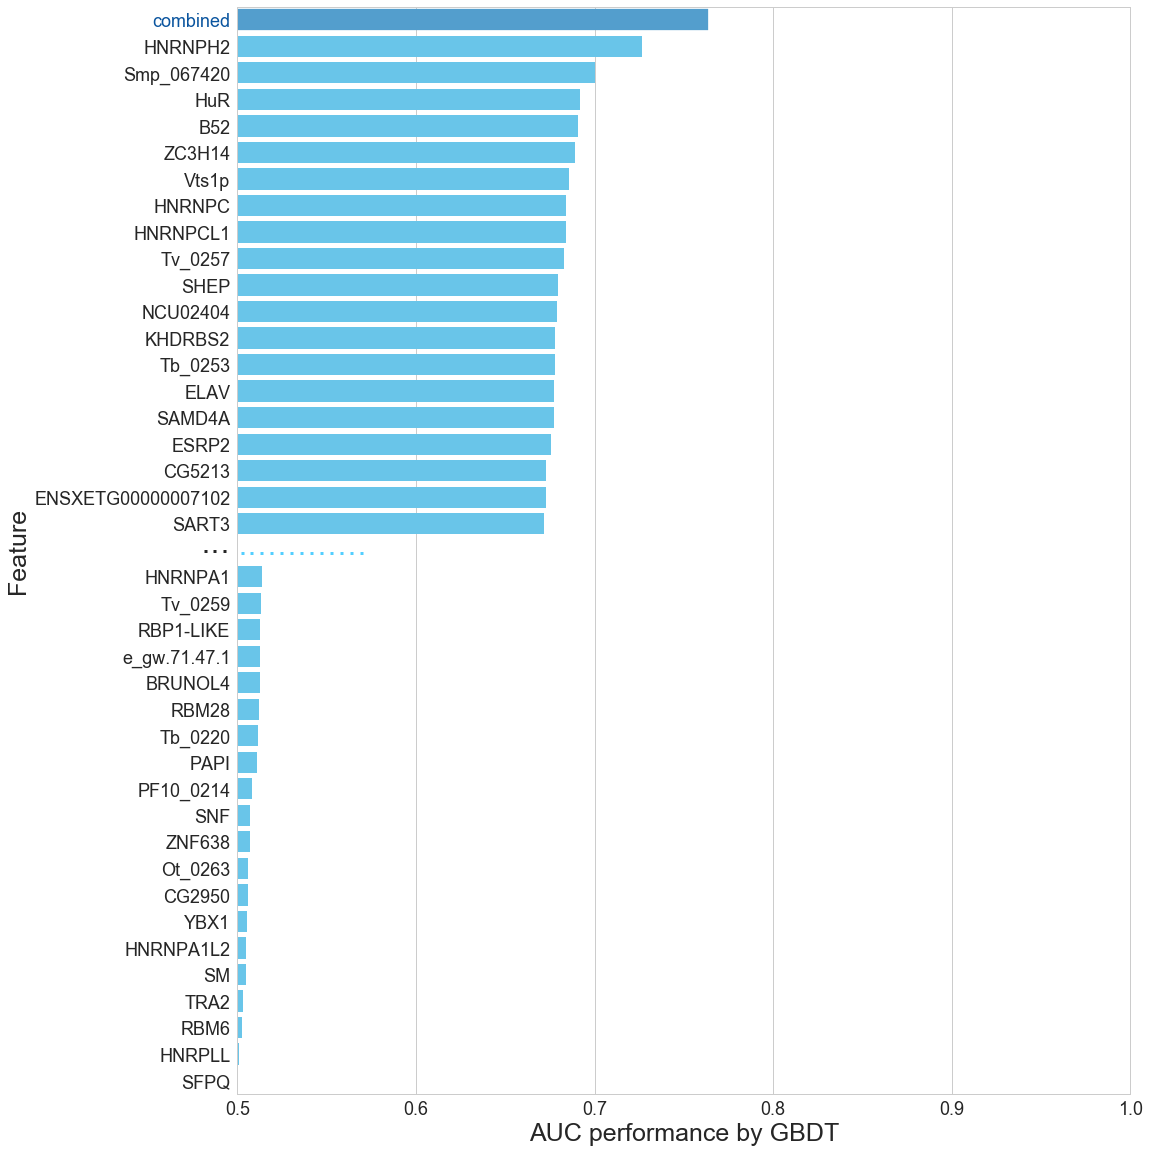

In [50]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

num_motifs = boxplot_mean_df.shape[0]
barplot_df = boxplot_mean_df.iloc[range(20)].append(pd.Series({u'···': 0})).append(boxplot_mean_df.iloc[range(num_motifs-20,num_motifs)])

plt.figure(figsize=(16,20))
ax = sns.barplot(barplot_df, barplot_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by GBDT', fontsize=25)
plt.yticks(fontsize=18)
plt.ylabel('Feature', fontsize=25)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

ax.get_yticklabels()[20].set_fontsize(30)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

plt.text(0.5, 20.5, u'·············', fontsize=30, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))

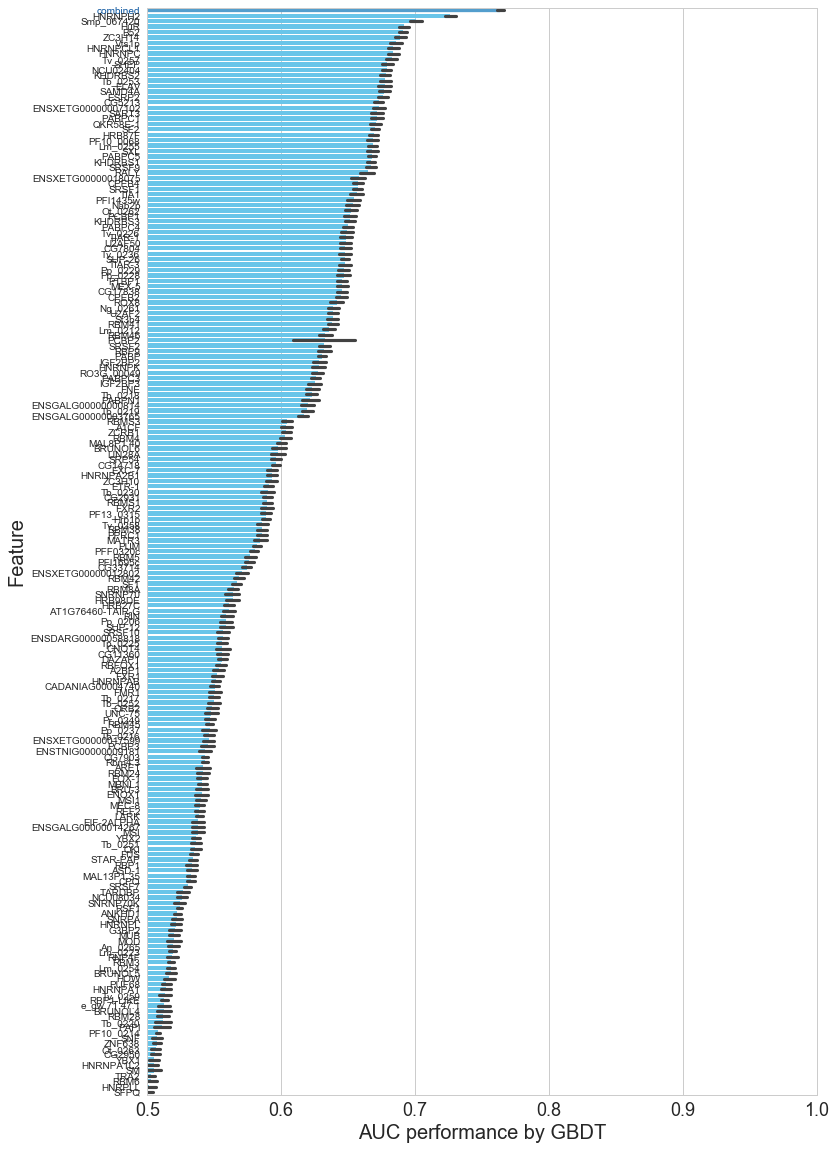

In [54]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

boxplot_errorbar_df = boxplot_df.set_index('feature')[['test auc']]
boxplot_errorbar_df['mean'] = boxplot_df.groupby('feature')['test auc'].mean()
boxplot_errorbar_df.sort_values(by='mean', ascending=False, inplace=True)
boxplot_errorbar_df = boxplot_errorbar_df['test auc']

plt.figure(figsize=(12,20))
#ax = sns.barplot(boxplot_mean_df, boxplot_mean_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
ax = sns.barplot(boxplot_errorbar_df, boxplot_errorbar_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by GBDT', fontsize=20)
plt.yticks(fontsize=10)
plt.ylabel('Feature', fontsize=20)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

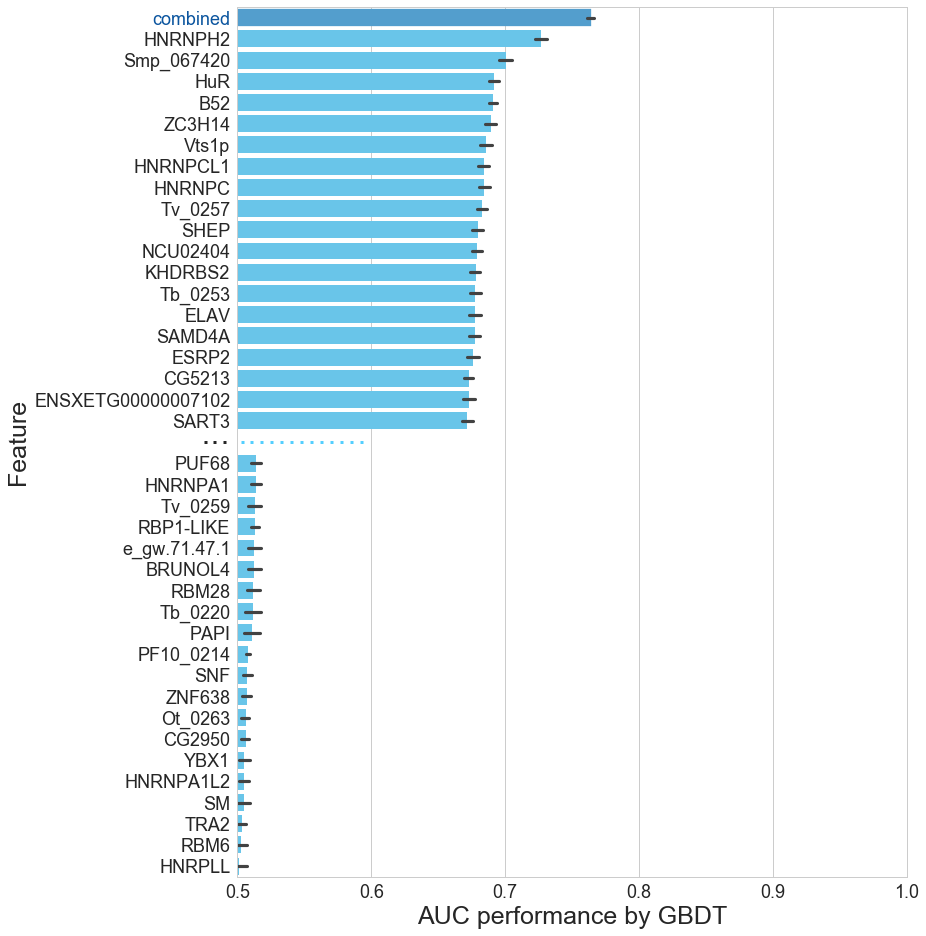

In [68]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

boxplot_errorbar_df = boxplot_df.set_index('feature')[['test auc']]
boxplot_errorbar_df['mean'] = boxplot_df.groupby('feature')['test auc'].mean()
boxplot_errorbar_df.sort_values(by='mean', ascending=False, inplace=True)
boxplot_errorbar_df = boxplot_errorbar_df['test auc']

num_motifs = boxplot_mean_df.shape[0]
num_rep = 20
barplot_df = boxplot_errorbar_df.iloc[range(20 * num_rep)].append(pd.Series({u'···': 0})).append(boxplot_errorbar_df.iloc[range((num_motifs-20) * num_rep, num_motifs * num_rep)])

plt.figure(figsize=(12,16))
ax = sns.barplot(barplot_df, barplot_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by GBDT', fontsize=25)
plt.yticks(fontsize=18)
plt.ylabel('Feature', fontsize=25)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

ax.get_yticklabels()[20].set_fontsize(30)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

plt.text(0.5, 20.5, u'·············', fontsize=30, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))

#### LR

In [69]:
auc_dict = {}

data_path = '/Users/zzeng/Documents/GitHub/ML_code/exp_IRI_intron_level_splicing/RBP'
for fname in filter(lambda f: re.search('exp_LR_st_add_motif_\S+log', f), os.listdir(data_path)):
    feature = re.search('exp_LR_st_add_motif_RBP_(\S+).log', fname).group(1)
    auc_dict[feature] = get_auc_list(os.path.join(data_path, fname))[1]

data_path = '/Users/zzeng/Documents/GitHub/ML_code/exp_IRI_intron_level_splicing'
fname = 'exp_LR_st_add_motif.log'
auc_dict.update({'combined': get_auc_list(os.path.join(data_path, fname))[1]})

In [70]:
boxplot_tuple = []
for feature in auc_dict.keys():
    for auc in auc_dict[feature]:
        boxplot_tuple.append((feature, auc))

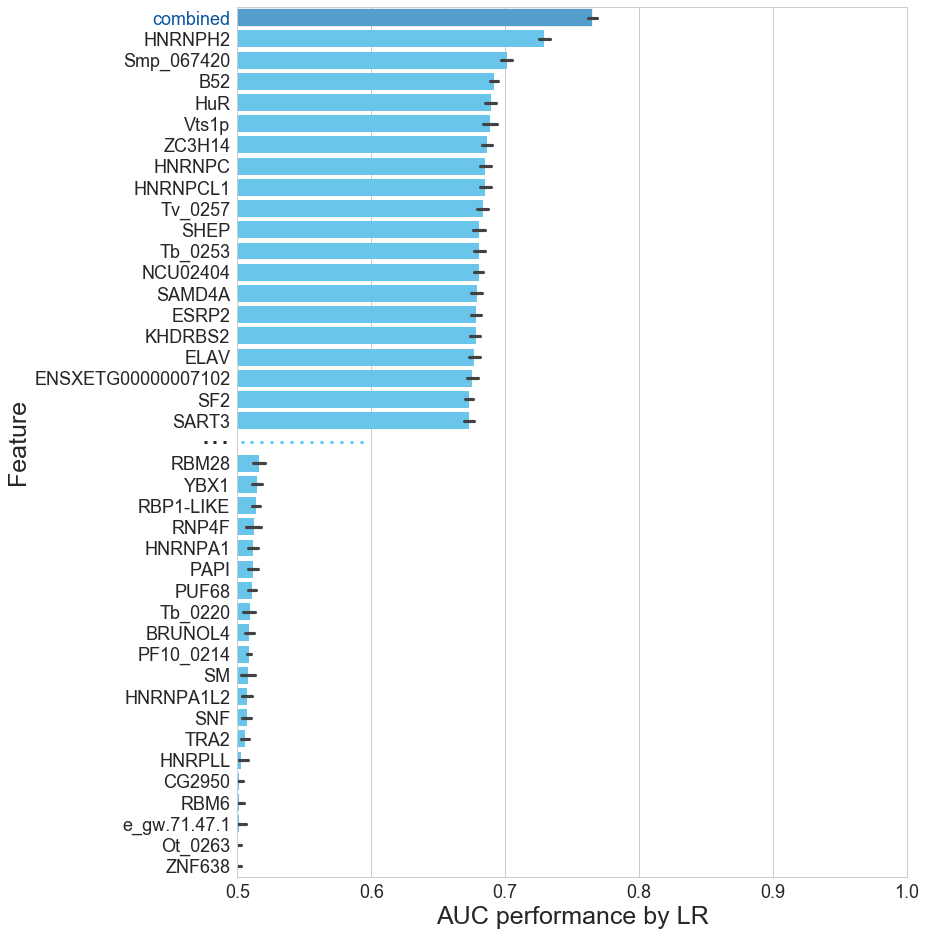

In [71]:
sns.set_style('whitegrid')

boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

boxplot_errorbar_df = boxplot_df.set_index('feature')[['test auc']]
boxplot_errorbar_df['mean'] = boxplot_df.groupby('feature')['test auc'].mean()
boxplot_errorbar_df.sort_values(by='mean', ascending=False, inplace=True)
boxplot_errorbar_df = boxplot_errorbar_df['test auc']

num_motifs = boxplot_mean_df.shape[0]
num_rep = 20
barplot_df = boxplot_errorbar_df.iloc[range(20 * num_rep)].append(pd.Series({u'···': 0})).append(boxplot_errorbar_df.iloc[range((num_motifs-20) * num_rep, num_motifs * num_rep)])

plt.figure(figsize=(12,16))
ax = sns.barplot(barplot_df, barplot_df.index, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))
plt.xlim([0.5,1])
plt.xticks(fontsize=18)
plt.xlabel('AUC performance by LR', fontsize=25)
plt.yticks(fontsize=18)
plt.ylabel('Feature', fontsize=25)

new_color = sns.color_palette("Blues")[5]
ax.get_yticklabels()[0].set_color(new_color)

ax.get_yticklabels()[20].set_fontsize(30)

new_color = sns.color_palette("Blues")[3]
ax.patches[0].set_color(new_color)

plt.text(0.5, 20.5, u'·············', fontsize=30, color=(83 / 255.0, 207 / 255.0, 255 / 255.0))

## pol II and H3K36Me3 suggest co-transcriptional splicing

In [6]:
epi_RPKM_df = pd.read_csv('/Users/zzeng/Documents/GitHub/ML_code/data/CD4_epigenetics_gene_RPKM.txt', header=0, sep='\t')
epi_IRI_df = pd.read_csv('/Users/zzeng/Documents/GitHub/ML_code/data/CD4_epigenetics_gene_IRI.txt', header=0, sep='\t')

epi_df = epi_IRI_df.merge(epi_RPKM_df, on='gene_id').set_index('gene_id')

In [5]:
df = pd.read_csv('/Users/zzeng/Documents/GitHub/ML_code/core_circuit/data/Human_summary/IRI/Rest_CD4.quant.IRI.genes.txt', header=0, sep='\t').loc[:,['gene_id', 'gene_CER_RPKM', 'gene_IRI']]
IRI_df = df[(df.gene_IRI >= 0) & (df.gene_IRI <= 1) & (df.gene_CER_RPKM >= 0.1)].drop(['gene_CER_RPKM'], axis=1).set_index('gene_id')

num_genes = 3000

IRI_high_genes = IRI_df.sort_values(by='gene_IRI', ascending=False).iloc[:num_genes].index.tolist()
IRI_low_genes = IRI_df.sort_values(by='gene_IRI').iloc[:num_genes].index.tolist()

In [9]:
boxplot_df_list = []

for mark in ['polII', 'H3K36me3']:
    expression_column = 'Rest_CD4_%s_RPKM' % mark
    IRI_column = 'Rest_CD4_%s_gene_IRI' % mark
    
    IRI_low_values = epi_df.loc[(epi_df[expression_column] >= 0.1) & (epi_df[IRI_column] >= 0) & (epi_df[IRI_column] <= 1), \
                                IRI_column].loc[IRI_low_genes].dropna()[:1000]
    
    IRI_high_values = epi_df.loc[(epi_df[expression_column] >= 0.1) & (epi_df[IRI_column] >= 0) & (epi_df[IRI_column] <= 1), \
                                 IRI_column].loc[IRI_high_genes].dropna()[:1000]
    

    
    boxplot_df_list.append(pd.DataFrame({'type': 'IR low genes', 'IRI': IRI_low_values, 'sample': mark}))
    boxplot_df_list.append(pd.DataFrame({'type': 'IR high genes', 'IRI': IRI_high_values, 'sample': mark}))

boxplot_df = pd.concat(boxplot_df_list, axis=0)

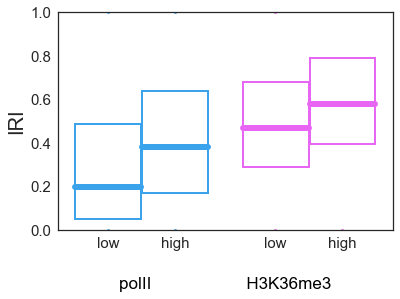

In [23]:
color_list = sns.color_palette('husl')[4:4+2]

plt.figure(figsize=(6,4))
ax = sns.boxplot(x='sample', y='IRI', hue='type', data=boxplot_df, showfliers=False)
ax.locator_params(nbins=5, axis='y')

box_upper_y_list = []

for k,artist in enumerate(ax.artists):
    color = color_list[k/2]
    artist.set_edgecolor(color)
    artist.set_facecolor('None')  

    artist.set_linewidth(2)
    for j in range(k*5, k*5+5):
        line = ax.lines[j]     
        line.set_color(color)
        if j % 5 in [0,1]:
            #line.set_linestyle('--')
            #line.set_dashes([2,4])
            #line.set_linewidth(0)
            line.set_color('None')
            if j % 5 == 1:
                box_upper_y_list.append(line.get_ydata()[0])
        if j % 5 in [2,3]:
            x1, x2 = line.get_xdata()
            line.set_xdata((x1+0.1, x2-0.1))
        if j % 5 in [4]:
            line.set_linewidth(6)
            pass


plt.legend([])
        
plt.ylabel('IRI', fontsize=20)
plt.yticks(size=15)

plt.ylim([0, 1])
plt.xticks([-0.2, 0.2, 0.8, 1.2],['low', 'high'] * 2, fontsize=15)
plt.xlabel('')

plt.title((' '*20).join(['polII', 'H3K36me3']), y=-0.3, fontsize=17, color='k')

In [14]:
boxplot_df.groupby(['sample', 'type']).count()

IRI
sample   type              
H3K36me3 IR high genes  404
         IR low genes   406
polII    IR high genes  423
         IR low genes   303

### eclip different binding strength in IR-low and IR-high introns

In [39]:
introns_RBP_binding_score_eclip_path = '/Users/zzeng/Documents/GitHub/ML_code/data/IRstat.RBP_binding_score_eclip_K562.introns.txt'
introns_RBP_binding_score_eclip_df = pd.read_csv(introns_RBP_binding_score_eclip_path, sep='\t', header=0)   

introns_RBP_binding_score_eclip_df.set_index('CIR_id', inplace=True)

In [42]:
data_path = '/Users/zzeng/Documents/GitHub/ML_code/core_circuit/data/Human_summary/IRI/introns'

num_samples = len(os.listdir(data_path))
df_list = []
for data_full_path in [os.path.join(data_path, f) for f in os.listdir(data_path) if re.search('introns.txt$', f)]:
    df = pd.read_csv(data_full_path, header=0, sep='\t', na_values=['NA', "NA (5'AS)", "NA (3'AS)", "NA (unannotated exon)"]).loc[:,['CIR_id', 'adjacent_CER_RPKM', 'intron_IRI']]
    df = df[(df.intron_IRI >= 0) & (df.intron_IRI <= 1) & (df.adjacent_CER_RPKM >= 0.1)].drop(['adjacent_CER_RPKM'], axis=1).set_index('CIR_id')
    df_list.append(df)    

IRI_df = pd.concat(df_list, axis=1).dropna()
IRI_df['mean_intron_IRI'] = IRI_df.apply(lambda row: np.mean(row[:num_samples]), axis=1)


num_IRI_high_CIRs = 5000
num_IRI_low_CIRs = 5000

IRI_high_CIR_list = IRI_df.sort_values(by='mean_intron_IRI', ascending=False).iloc[:num_IRI_high_CIRs].index.tolist()
IRI_low_CIR_list = IRI_df.sort_values(by='mean_intron_IRI').iloc[:num_IRI_low_CIRs].index.tolist()

In [ ]:
auc_dict = {}

data_path = '/Users/zzeng/Documents/GitHub/ML_code/exp_IRI_intron_level_splicing/RBP'
for fname in filter(lambda f: re.search('exp_gbtree_add_eclip_\S+log', f), os.listdir(data_path)):
    feature = re.search('exp_gbtree_add_eclip_RBP_(\S+).log', fname).group(1)
    auc_dict[feature] = get_auc_list(os.path.join(data_path, fname))[1]

data_path = '/Users/zzeng/Documents/GitHub/ML_code/exp_IRI_intron_level_splicing'
fname = 'exp_gbtree_add_eclip.log'
auc_dict.update({'combined': get_auc_list(os.path.join(data_path, fname))[1]})

In [51]:
boxplot_tuple = []
for feature in auc_dict.keys():
    for auc in auc_dict[feature]:
        boxplot_tuple.append((feature, auc))

In [52]:
boxplot_df = pd.DataFrame(boxplot_tuple, columns=['feature', 'test auc'])
boxplot_mean_df = boxplot_df.groupby('feature')['test auc'].mean().sort_values(ascending=False)

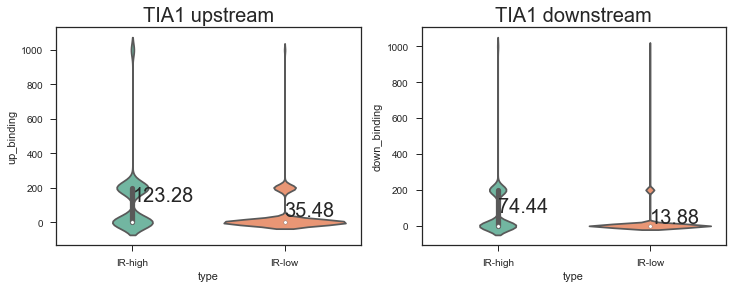

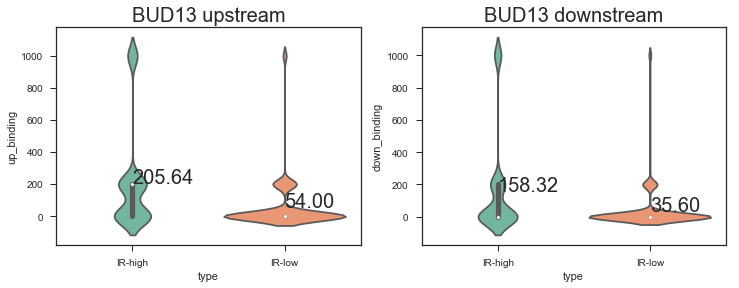

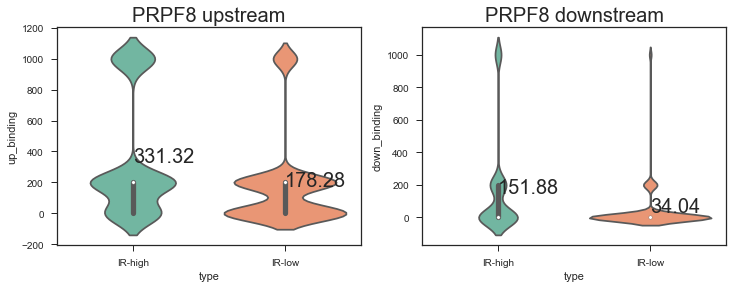

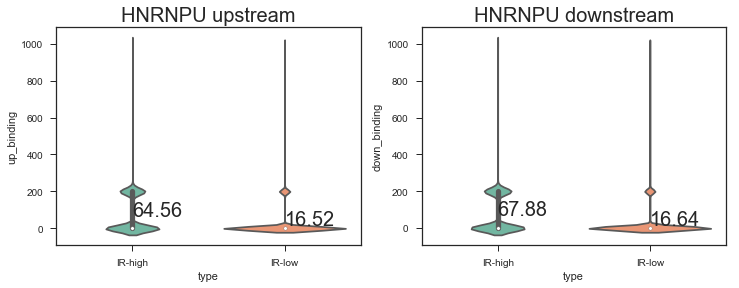

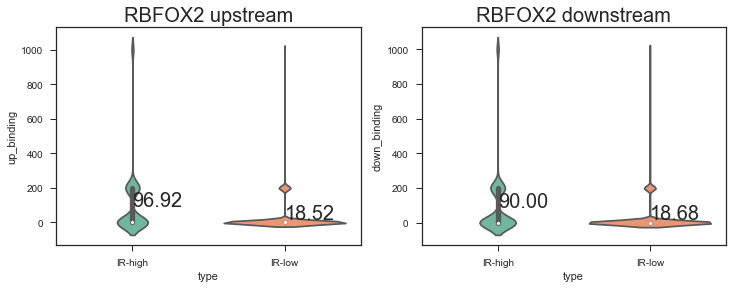

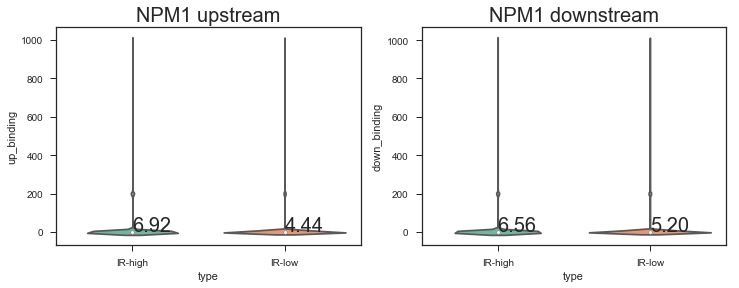

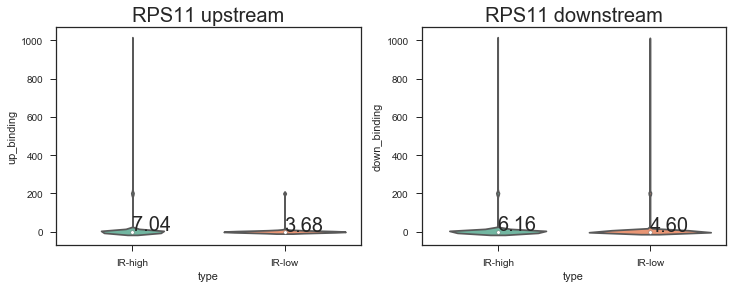

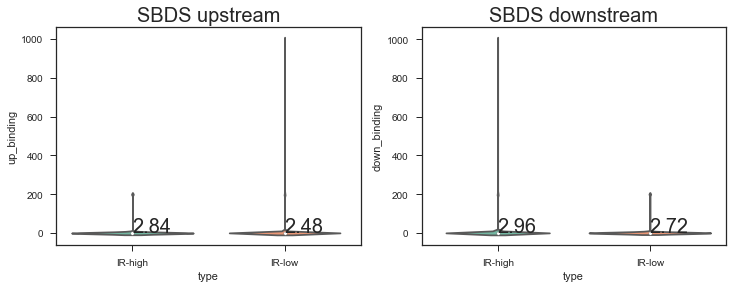

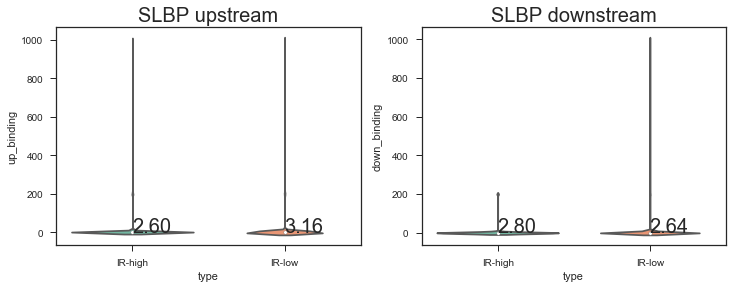

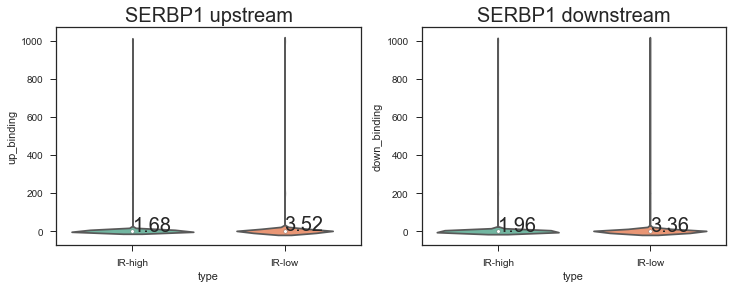

In [131]:
for RBP_name in (boxplot_mean_df[1:6].index.tolist() + boxplot_mean_df[-5:].index.tolist()):
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12,4))
    for i, pos in enumerate(['up', 'down']):
        plt.subplot(1,2,i+1)
        
        boxplot_df = pd.concat([pd.DataFrame({pos+'_binding': introns_RBP_binding_score_eclip_df.filter(regex=pos+'\S+'+RBP_name).loc[IRI_high_CIR_list,:].iloc[:,0], 'type': 'IR-high'}),
                                pd.DataFrame({pos+'_binding': introns_RBP_binding_score_eclip_df.filter(regex=pos+'\S+'+RBP_name).loc[IRI_low_CIR_list,:].iloc[:,0], 'type': 'IR-low'})],
                               axis=0)
        
        sns.violinplot(x='type', y=pos+'_binding', data=boxplot_df)
        for index, type in enumerate(['IR-high', 'IR-low']):
            value = boxplot_df[boxplot_df.type == type].mean()
            plt.annotate('%.2f' % value, (index, value), fontsize=20)
        plt.title(RBP_name + ' ' + pos + 'stream', fontsize=20)
    plt.show()

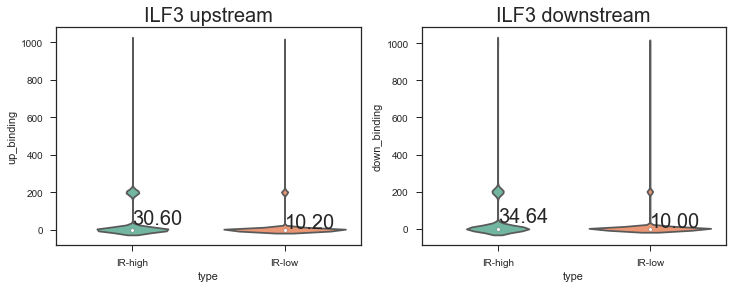

In [134]:
for RBP_name in (['ILF3']):
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12,4))
    for i, pos in enumerate(['up', 'down']):
        plt.subplot(1,2,i+1)
        
        boxplot_df = pd.concat([pd.DataFrame({pos+'_binding': introns_RBP_binding_score_eclip_df.filter(regex=pos+'\S+'+RBP_name).loc[IRI_high_CIR_list,:].iloc[:,0], 'type': 'IR-high'}),
                                pd.DataFrame({pos+'_binding': introns_RBP_binding_score_eclip_df.filter(regex=pos+'\S+'+RBP_name).loc[IRI_low_CIR_list,:].iloc[:,0], 'type': 'IR-low'})],
                               axis=0)
        
        sns.violinplot(x='type', y=pos+'_binding', data=boxplot_df)
        for index, type in enumerate(['IR-high', 'IR-low']):
            value = boxplot_df[boxplot_df.type == type].mean()
            plt.annotate('%.2f' % value, (index, value), fontsize=20)
        plt.title(RBP_name + ' ' + pos + 'stream', fontsize=20)
    plt.show()

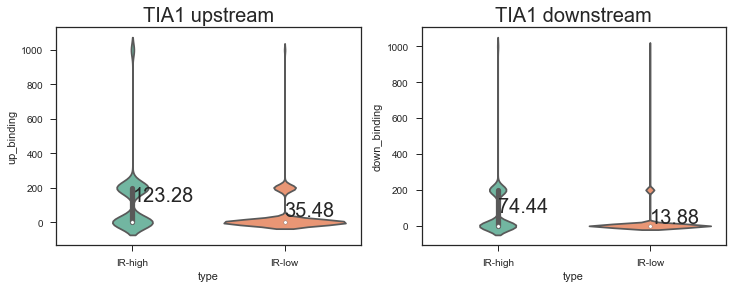

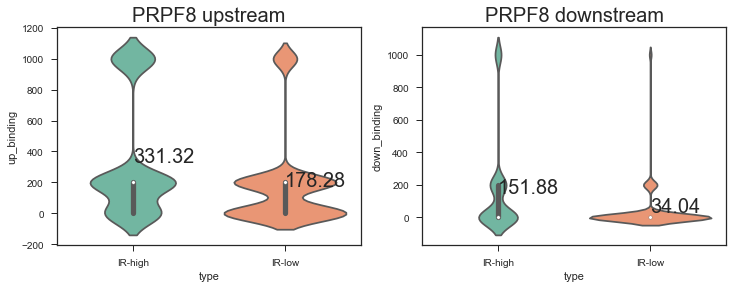

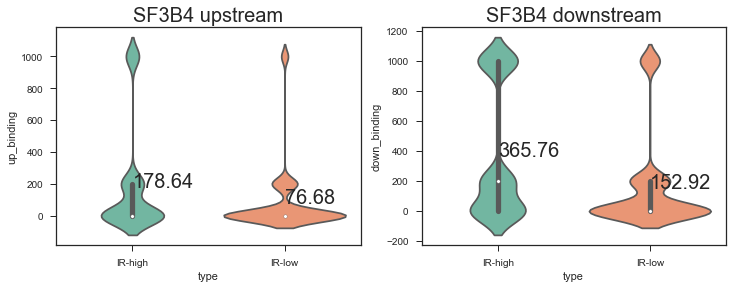

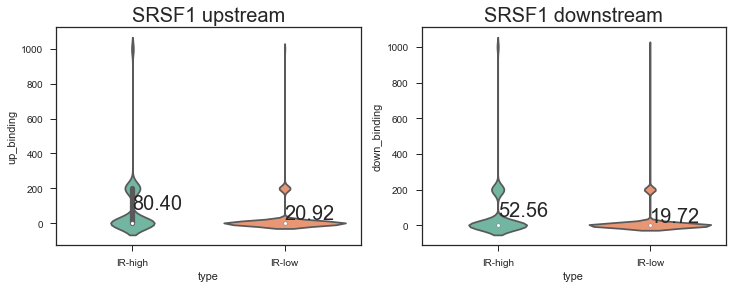

In [135]:
for RBP_name in (['TIA1', 'PRPF8', 'SF3B4', 'SRSF1']):
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12,4))
    for i, pos in enumerate(['up', 'down']):
        plt.subplot(1,2,i+1)
        
        boxplot_df = pd.concat([pd.DataFrame({pos+'_binding': introns_RBP_binding_score_eclip_df.filter(regex=pos+'\S+'+RBP_name).loc[IRI_high_CIR_list,:].iloc[:,0], 'type': 'IR-high'}),
                                pd.DataFrame({pos+'_binding': introns_RBP_binding_score_eclip_df.filter(regex=pos+'\S+'+RBP_name).loc[IRI_low_CIR_list,:].iloc[:,0], 'type': 'IR-low'})],
                               axis=0)
        
        sns.violinplot(x='type', y=pos+'_binding', data=boxplot_df)
        for index, type in enumerate(['IR-high', 'IR-low']):
            value = boxplot_df[boxplot_df.type == type].mean()
            plt.annotate('%.2f' % value, (index, value), fontsize=20)
        plt.title(RBP_name + ' ' + pos + 'stream', fontsize=20)
    plt.show()